In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import seaborn as sns
from pathlib import Path
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
data_dir = Path('./data/')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 10
n_class = 3
seed = 42

In [5]:
algo_name = 'lgbcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = data_dir / f'{feature_name}.csv'
p_val_file = data_dir / f'{model_name}.val.csv'
p_tst_file = data_dir / f'{model_name}.tst.csv'
sub_file = data_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 25)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_zi,d_dered_zr,d_dered_zg,d_dered_zu,d_dered_ir,d_dered_ig,d_dered_iu,d_dered_ru,d_dered_gu,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-0.7232,-2.0462,-3.3488,-6.2153,-1.3230,-2.6257,-5.4921,-4.1691,-2.8665,6.1132
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.1016,-0.2767,-0.8698,-1.8317,-0.1751,-0.7683,-1.7302,-1.5550,-0.9619,1.4427
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.0257,-0.1440,-0.3905,-1.3116,-0.1183,-0.3649,-1.2859,-1.1676,-0.9211,1.8205
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-0.2395,-0.5321,-1.4395,-5.7985,-0.2926,-1.2000,-5.5590,-5.2664,-4.3590,1.8640
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-0.3144,-0.9871,-2.5579,-5.8955,-0.6727,-2.2436,-5.5811,-4.9084,-3.3376,4.5471


In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 24) (80000, 24)


In [8]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [10]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             boosting_type='gbdt',
                             n_estimators=16608,
                             max_depth=27,
                             num_iterations=14278, # 3번째 모델부터 성능 하락
                             num_leaves=138,
                             learning_rate=0.005,
                             min_child_samples=255,
                             subsample=.9,
                             subsample_freq=1,
                             colsample_bytree=.9,
                             random_state=42,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=100)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.978301
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.970702
[3]	valid_0's multi_logloss: 0.963207
[4]	valid_0's multi_logloss: 0.956215
[5]	valid_0's multi_logloss: 0.9489
[6]	valid_0's multi_logloss: 0.9417
[7]	valid_0's multi_logloss: 0.935249
[8]	valid_0's multi_logloss: 0.928226
[9]	valid_0's multi_logloss: 0.921311
[10]	valid_0's multi_logloss: 0.914482
[11]	valid_0's multi_logloss: 0.908127
[12]	valid_0's multi_logloss: 0.901465
[13]	valid_0's multi_logloss: 0.895244
[14]	valid_0's multi_logloss: 0.88875
[15]	valid_0's multi_logloss: 0.882328
[16]	valid_0's multi_logloss: 0.875993
[17]	valid_0's multi_logloss: 0.869735
[18]	valid_0's multi_logloss: 0.863556
[19]	valid_0's multi_logloss: 0.857477
[20]	valid_0's multi_logloss: 0.851492
[21]	valid_0's multi_logloss: 0.845532
[22]	valid_0's multi_logloss: 0.839664
[23]	valid_0's multi_logloss: 0.833847
[24]	valid_0's multi_logloss: 

[208]	valid_0's multi_logloss: 0.335552
[209]	valid_0's multi_logloss: 0.334389
[210]	valid_0's multi_logloss: 0.333245
[211]	valid_0's multi_logloss: 0.332104
[212]	valid_0's multi_logloss: 0.33098
[213]	valid_0's multi_logloss: 0.329865
[214]	valid_0's multi_logloss: 0.328825
[215]	valid_0's multi_logloss: 0.327769
[216]	valid_0's multi_logloss: 0.326674
[217]	valid_0's multi_logloss: 0.32559
[218]	valid_0's multi_logloss: 0.324598
[219]	valid_0's multi_logloss: 0.323523
[220]	valid_0's multi_logloss: 0.322449
[221]	valid_0's multi_logloss: 0.321522
[222]	valid_0's multi_logloss: 0.320493
[223]	valid_0's multi_logloss: 0.319501
[224]	valid_0's multi_logloss: 0.318465
[225]	valid_0's multi_logloss: 0.31745
[226]	valid_0's multi_logloss: 0.316426
[227]	valid_0's multi_logloss: 0.315417
[228]	valid_0's multi_logloss: 0.314409
[229]	valid_0's multi_logloss: 0.31341
[230]	valid_0's multi_logloss: 0.312417
[231]	valid_0's multi_logloss: 0.311431
[232]	valid_0's multi_logloss: 0.310449
[233

[416]	valid_0's multi_logloss: 0.20904
[417]	valid_0's multi_logloss: 0.208758
[418]	valid_0's multi_logloss: 0.208472
[419]	valid_0's multi_logloss: 0.208199
[420]	valid_0's multi_logloss: 0.207913
[421]	valid_0's multi_logloss: 0.20763
[422]	valid_0's multi_logloss: 0.207346
[423]	valid_0's multi_logloss: 0.207086
[424]	valid_0's multi_logloss: 0.206809
[425]	valid_0's multi_logloss: 0.206535
[426]	valid_0's multi_logloss: 0.20626
[427]	valid_0's multi_logloss: 0.205986
[428]	valid_0's multi_logloss: 0.205717
[429]	valid_0's multi_logloss: 0.205446
[430]	valid_0's multi_logloss: 0.205181
[431]	valid_0's multi_logloss: 0.204914
[432]	valid_0's multi_logloss: 0.204651
[433]	valid_0's multi_logloss: 0.204398
[434]	valid_0's multi_logloss: 0.204138
[435]	valid_0's multi_logloss: 0.203874
[436]	valid_0's multi_logloss: 0.203614
[437]	valid_0's multi_logloss: 0.203365
[438]	valid_0's multi_logloss: 0.203111
[439]	valid_0's multi_logloss: 0.202882
[440]	valid_0's multi_logloss: 0.202629
[44

[622]	valid_0's multi_logloss: 0.174478
[623]	valid_0's multi_logloss: 0.174392
[624]	valid_0's multi_logloss: 0.1743
[625]	valid_0's multi_logloss: 0.17421
[626]	valid_0's multi_logloss: 0.17412
[627]	valid_0's multi_logloss: 0.174044
[628]	valid_0's multi_logloss: 0.173964
[629]	valid_0's multi_logloss: 0.173874
[630]	valid_0's multi_logloss: 0.173791
[631]	valid_0's multi_logloss: 0.173705
[632]	valid_0's multi_logloss: 0.173616
[633]	valid_0's multi_logloss: 0.173537
[634]	valid_0's multi_logloss: 0.173454
[635]	valid_0's multi_logloss: 0.173371
[636]	valid_0's multi_logloss: 0.173289
[637]	valid_0's multi_logloss: 0.1732
[638]	valid_0's multi_logloss: 0.173113
[639]	valid_0's multi_logloss: 0.173028
[640]	valid_0's multi_logloss: 0.172954
[641]	valid_0's multi_logloss: 0.172872
[642]	valid_0's multi_logloss: 0.172791
[643]	valid_0's multi_logloss: 0.172709
[644]	valid_0's multi_logloss: 0.172625
[645]	valid_0's multi_logloss: 0.172551
[646]	valid_0's multi_logloss: 0.172467
[647]	

[830]	valid_0's multi_logloss: 0.162771
[831]	valid_0's multi_logloss: 0.162734
[832]	valid_0's multi_logloss: 0.162701
[833]	valid_0's multi_logloss: 0.162668
[834]	valid_0's multi_logloss: 0.162635
[835]	valid_0's multi_logloss: 0.162605
[836]	valid_0's multi_logloss: 0.162571
[837]	valid_0's multi_logloss: 0.162538
[838]	valid_0's multi_logloss: 0.162504
[839]	valid_0's multi_logloss: 0.162466
[840]	valid_0's multi_logloss: 0.162437
[841]	valid_0's multi_logloss: 0.162406
[842]	valid_0's multi_logloss: 0.162374
[843]	valid_0's multi_logloss: 0.162338
[844]	valid_0's multi_logloss: 0.162305
[845]	valid_0's multi_logloss: 0.162272
[846]	valid_0's multi_logloss: 0.162239
[847]	valid_0's multi_logloss: 0.162205
[848]	valid_0's multi_logloss: 0.162171
[849]	valid_0's multi_logloss: 0.162139
[850]	valid_0's multi_logloss: 0.16211
[851]	valid_0's multi_logloss: 0.16208
[852]	valid_0's multi_logloss: 0.162049
[853]	valid_0's multi_logloss: 0.162017
[854]	valid_0's multi_logloss: 0.161986
[8

[1037]	valid_0's multi_logloss: 0.157977
[1038]	valid_0's multi_logloss: 0.15796
[1039]	valid_0's multi_logloss: 0.15794
[1040]	valid_0's multi_logloss: 0.157925
[1041]	valid_0's multi_logloss: 0.157909
[1042]	valid_0's multi_logloss: 0.157892
[1043]	valid_0's multi_logloss: 0.157879
[1044]	valid_0's multi_logloss: 0.157863
[1045]	valid_0's multi_logloss: 0.157848
[1046]	valid_0's multi_logloss: 0.157834
[1047]	valid_0's multi_logloss: 0.15782
[1048]	valid_0's multi_logloss: 0.157804
[1049]	valid_0's multi_logloss: 0.15779
[1050]	valid_0's multi_logloss: 0.157777
[1051]	valid_0's multi_logloss: 0.157763
[1052]	valid_0's multi_logloss: 0.15775
[1053]	valid_0's multi_logloss: 0.157737
[1054]	valid_0's multi_logloss: 0.157721
[1055]	valid_0's multi_logloss: 0.157703
[1056]	valid_0's multi_logloss: 0.157688
[1057]	valid_0's multi_logloss: 0.157675
[1058]	valid_0's multi_logloss: 0.157662
[1059]	valid_0's multi_logloss: 0.157649
[1060]	valid_0's multi_logloss: 0.157635
[1061]	valid_0's mult

[1240]	valid_0's multi_logloss: 0.155656
[1241]	valid_0's multi_logloss: 0.155646
[1242]	valid_0's multi_logloss: 0.155638
[1243]	valid_0's multi_logloss: 0.155629
[1244]	valid_0's multi_logloss: 0.155619
[1245]	valid_0's multi_logloss: 0.155611
[1246]	valid_0's multi_logloss: 0.155601
[1247]	valid_0's multi_logloss: 0.155596
[1248]	valid_0's multi_logloss: 0.155588
[1249]	valid_0's multi_logloss: 0.155579
[1250]	valid_0's multi_logloss: 0.155571
[1251]	valid_0's multi_logloss: 0.155564
[1252]	valid_0's multi_logloss: 0.155557
[1253]	valid_0's multi_logloss: 0.155551
[1254]	valid_0's multi_logloss: 0.155545
[1255]	valid_0's multi_logloss: 0.155535
[1256]	valid_0's multi_logloss: 0.155527
[1257]	valid_0's multi_logloss: 0.155521
[1258]	valid_0's multi_logloss: 0.155515
[1259]	valid_0's multi_logloss: 0.155508
[1260]	valid_0's multi_logloss: 0.155504
[1261]	valid_0's multi_logloss: 0.155497
[1262]	valid_0's multi_logloss: 0.155492
[1263]	valid_0's multi_logloss: 0.155482
[1264]	valid_0's

[1440]	valid_0's multi_logloss: 0.154487
[1441]	valid_0's multi_logloss: 0.154483
[1442]	valid_0's multi_logloss: 0.154479
[1443]	valid_0's multi_logloss: 0.154475
[1444]	valid_0's multi_logloss: 0.154468
[1445]	valid_0's multi_logloss: 0.154461
[1446]	valid_0's multi_logloss: 0.154454
[1447]	valid_0's multi_logloss: 0.154451
[1448]	valid_0's multi_logloss: 0.154442
[1449]	valid_0's multi_logloss: 0.154438
[1450]	valid_0's multi_logloss: 0.154433
[1451]	valid_0's multi_logloss: 0.154431
[1452]	valid_0's multi_logloss: 0.154429
[1453]	valid_0's multi_logloss: 0.154424
[1454]	valid_0's multi_logloss: 0.154421
[1455]	valid_0's multi_logloss: 0.154416
[1456]	valid_0's multi_logloss: 0.15441
[1457]	valid_0's multi_logloss: 0.154406
[1458]	valid_0's multi_logloss: 0.154402
[1459]	valid_0's multi_logloss: 0.154397
[1460]	valid_0's multi_logloss: 0.154395
[1461]	valid_0's multi_logloss: 0.15439
[1462]	valid_0's multi_logloss: 0.154388
[1463]	valid_0's multi_logloss: 0.154385
[1464]	valid_0's m

[1641]	valid_0's multi_logloss: 0.153803
[1642]	valid_0's multi_logloss: 0.153802
[1643]	valid_0's multi_logloss: 0.153798
[1644]	valid_0's multi_logloss: 0.153796
[1645]	valid_0's multi_logloss: 0.153795
[1646]	valid_0's multi_logloss: 0.153794
[1647]	valid_0's multi_logloss: 0.153793
[1648]	valid_0's multi_logloss: 0.153791
[1649]	valid_0's multi_logloss: 0.153786
[1650]	valid_0's multi_logloss: 0.153785
[1651]	valid_0's multi_logloss: 0.153783
[1652]	valid_0's multi_logloss: 0.15378
[1653]	valid_0's multi_logloss: 0.153776
[1654]	valid_0's multi_logloss: 0.153773
[1655]	valid_0's multi_logloss: 0.153769
[1656]	valid_0's multi_logloss: 0.153764
[1657]	valid_0's multi_logloss: 0.153761
[1658]	valid_0's multi_logloss: 0.153758
[1659]	valid_0's multi_logloss: 0.153758
[1660]	valid_0's multi_logloss: 0.153752
[1661]	valid_0's multi_logloss: 0.153749
[1662]	valid_0's multi_logloss: 0.153746
[1663]	valid_0's multi_logloss: 0.153741
[1664]	valid_0's multi_logloss: 0.153738
[1665]	valid_0's 

[1844]	valid_0's multi_logloss: 0.153371
[1845]	valid_0's multi_logloss: 0.15337
[1846]	valid_0's multi_logloss: 0.15337
[1847]	valid_0's multi_logloss: 0.15337
[1848]	valid_0's multi_logloss: 0.153371
[1849]	valid_0's multi_logloss: 0.15337
[1850]	valid_0's multi_logloss: 0.15337
[1851]	valid_0's multi_logloss: 0.153367
[1852]	valid_0's multi_logloss: 0.153365
[1853]	valid_0's multi_logloss: 0.153364
[1854]	valid_0's multi_logloss: 0.153362
[1855]	valid_0's multi_logloss: 0.153357
[1856]	valid_0's multi_logloss: 0.153357
[1857]	valid_0's multi_logloss: 0.153356
[1858]	valid_0's multi_logloss: 0.153353
[1859]	valid_0's multi_logloss: 0.153351
[1860]	valid_0's multi_logloss: 0.153349
[1861]	valid_0's multi_logloss: 0.153347
[1862]	valid_0's multi_logloss: 0.153349
[1863]	valid_0's multi_logloss: 0.153347
[1864]	valid_0's multi_logloss: 0.153344
[1865]	valid_0's multi_logloss: 0.153345
[1866]	valid_0's multi_logloss: 0.15334
[1867]	valid_0's multi_logloss: 0.153339
[1868]	valid_0's multi

[2047]	valid_0's multi_logloss: 0.153178
[2048]	valid_0's multi_logloss: 0.153176
[2049]	valid_0's multi_logloss: 0.153177
[2050]	valid_0's multi_logloss: 0.153178
[2051]	valid_0's multi_logloss: 0.153176
[2052]	valid_0's multi_logloss: 0.153175
[2053]	valid_0's multi_logloss: 0.153175
[2054]	valid_0's multi_logloss: 0.153173
[2055]	valid_0's multi_logloss: 0.153173
[2056]	valid_0's multi_logloss: 0.153174
[2057]	valid_0's multi_logloss: 0.153174
[2058]	valid_0's multi_logloss: 0.153174
[2059]	valid_0's multi_logloss: 0.153173
[2060]	valid_0's multi_logloss: 0.153172
[2061]	valid_0's multi_logloss: 0.153173
[2062]	valid_0's multi_logloss: 0.153171
[2063]	valid_0's multi_logloss: 0.153168
[2064]	valid_0's multi_logloss: 0.153168
[2065]	valid_0's multi_logloss: 0.15317
[2066]	valid_0's multi_logloss: 0.153171
[2067]	valid_0's multi_logloss: 0.153171
[2068]	valid_0's multi_logloss: 0.15317
[2069]	valid_0's multi_logloss: 0.15317
[2070]	valid_0's multi_logloss: 0.153171
[2071]	valid_0's mu

[2247]	valid_0's multi_logloss: 0.153082
[2248]	valid_0's multi_logloss: 0.153081
[2249]	valid_0's multi_logloss: 0.153079
[2250]	valid_0's multi_logloss: 0.153082
[2251]	valid_0's multi_logloss: 0.153082
[2252]	valid_0's multi_logloss: 0.153084
[2253]	valid_0's multi_logloss: 0.153085
[2254]	valid_0's multi_logloss: 0.153085
[2255]	valid_0's multi_logloss: 0.153083
[2256]	valid_0's multi_logloss: 0.153083
[2257]	valid_0's multi_logloss: 0.153082
[2258]	valid_0's multi_logloss: 0.153079
[2259]	valid_0's multi_logloss: 0.153079
[2260]	valid_0's multi_logloss: 0.153076
[2261]	valid_0's multi_logloss: 0.153073
[2262]	valid_0's multi_logloss: 0.153074
[2263]	valid_0's multi_logloss: 0.153075
[2264]	valid_0's multi_logloss: 0.153072
[2265]	valid_0's multi_logloss: 0.153071
[2266]	valid_0's multi_logloss: 0.153071
[2267]	valid_0's multi_logloss: 0.15307
[2268]	valid_0's multi_logloss: 0.153069
[2269]	valid_0's multi_logloss: 0.15307
[2270]	valid_0's multi_logloss: 0.153069
[2271]	valid_0's m

[2448]	valid_0's multi_logloss: 0.153036
[2449]	valid_0's multi_logloss: 0.153035
[2450]	valid_0's multi_logloss: 0.153035
[2451]	valid_0's multi_logloss: 0.153037
[2452]	valid_0's multi_logloss: 0.153034
[2453]	valid_0's multi_logloss: 0.153035
[2454]	valid_0's multi_logloss: 0.153035
[2455]	valid_0's multi_logloss: 0.153034
[2456]	valid_0's multi_logloss: 0.15303
[2457]	valid_0's multi_logloss: 0.153032
[2458]	valid_0's multi_logloss: 0.15303
[2459]	valid_0's multi_logloss: 0.15303
[2460]	valid_0's multi_logloss: 0.153029
[2461]	valid_0's multi_logloss: 0.153029
[2462]	valid_0's multi_logloss: 0.153033
[2463]	valid_0's multi_logloss: 0.153034
[2464]	valid_0's multi_logloss: 0.153033
[2465]	valid_0's multi_logloss: 0.153033
[2466]	valid_0's multi_logloss: 0.153036
[2467]	valid_0's multi_logloss: 0.153036
[2468]	valid_0's multi_logloss: 0.153037
[2469]	valid_0's multi_logloss: 0.153037
[2470]	valid_0's multi_logloss: 0.153037
[2471]	valid_0's multi_logloss: 0.153034
[2472]	valid_0's mu

[90]	valid_0's multi_logloss: 0.559112
[91]	valid_0's multi_logloss: 0.556162
[92]	valid_0's multi_logloss: 0.553232
[93]	valid_0's multi_logloss: 0.550331
[94]	valid_0's multi_logloss: 0.547454
[95]	valid_0's multi_logloss: 0.544608
[96]	valid_0's multi_logloss: 0.54196
[97]	valid_0's multi_logloss: 0.53915
[98]	valid_0's multi_logloss: 0.536379
[99]	valid_0's multi_logloss: 0.533627
[100]	valid_0's multi_logloss: 0.530907
[101]	valid_0's multi_logloss: 0.528207
[102]	valid_0's multi_logloss: 0.525524
[103]	valid_0's multi_logloss: 0.522867
[104]	valid_0's multi_logloss: 0.520234
[105]	valid_0's multi_logloss: 0.517642
[106]	valid_0's multi_logloss: 0.515054
[107]	valid_0's multi_logloss: 0.51249
[108]	valid_0's multi_logloss: 0.509935
[109]	valid_0's multi_logloss: 0.507549
[110]	valid_0's multi_logloss: 0.505041
[111]	valid_0's multi_logloss: 0.502562
[112]	valid_0's multi_logloss: 0.500096
[113]	valid_0's multi_logloss: 0.497657
[114]	valid_0's multi_logloss: 0.495252
[115]	valid_0

[298]	valid_0's multi_logloss: 0.261056
[299]	valid_0's multi_logloss: 0.260435
[300]	valid_0's multi_logloss: 0.259824
[301]	valid_0's multi_logloss: 0.259216
[302]	valid_0's multi_logloss: 0.25865
[303]	valid_0's multi_logloss: 0.258056
[304]	valid_0's multi_logloss: 0.257458
[305]	valid_0's multi_logloss: 0.256865
[306]	valid_0's multi_logloss: 0.256276
[307]	valid_0's multi_logloss: 0.25569
[308]	valid_0's multi_logloss: 0.255105
[309]	valid_0's multi_logloss: 0.254571
[310]	valid_0's multi_logloss: 0.253996
[311]	valid_0's multi_logloss: 0.253427
[312]	valid_0's multi_logloss: 0.252868
[313]	valid_0's multi_logloss: 0.252311
[314]	valid_0's multi_logloss: 0.251756
[315]	valid_0's multi_logloss: 0.251203
[316]	valid_0's multi_logloss: 0.250649
[317]	valid_0's multi_logloss: 0.250102
[318]	valid_0's multi_logloss: 0.249566
[319]	valid_0's multi_logloss: 0.249029
[320]	valid_0's multi_logloss: 0.248494
[321]	valid_0's multi_logloss: 0.248005
[322]	valid_0's multi_logloss: 0.247472
[3

[505]	valid_0's multi_logloss: 0.190729
[506]	valid_0's multi_logloss: 0.190557
[507]	valid_0's multi_logloss: 0.190391
[508]	valid_0's multi_logloss: 0.190229
[509]	valid_0's multi_logloss: 0.190054
[510]	valid_0's multi_logloss: 0.189886
[511]	valid_0's multi_logloss: 0.189724
[512]	valid_0's multi_logloss: 0.189554
[513]	valid_0's multi_logloss: 0.189384
[514]	valid_0's multi_logloss: 0.18922
[515]	valid_0's multi_logloss: 0.189053
[516]	valid_0's multi_logloss: 0.188888
[517]	valid_0's multi_logloss: 0.188729
[518]	valid_0's multi_logloss: 0.188569
[519]	valid_0's multi_logloss: 0.188406
[520]	valid_0's multi_logloss: 0.188244
[521]	valid_0's multi_logloss: 0.188079
[522]	valid_0's multi_logloss: 0.187921
[523]	valid_0's multi_logloss: 0.187759
[524]	valid_0's multi_logloss: 0.187602
[525]	valid_0's multi_logloss: 0.187441
[526]	valid_0's multi_logloss: 0.18729
[527]	valid_0's multi_logloss: 0.187135
[528]	valid_0's multi_logloss: 0.186979
[529]	valid_0's multi_logloss: 0.186826
[5

[711]	valid_0's multi_logloss: 0.169299
[712]	valid_0's multi_logloss: 0.169242
[713]	valid_0's multi_logloss: 0.16918
[714]	valid_0's multi_logloss: 0.169122
[715]	valid_0's multi_logloss: 0.169066
[716]	valid_0's multi_logloss: 0.169012
[717]	valid_0's multi_logloss: 0.168953
[718]	valid_0's multi_logloss: 0.168895
[719]	valid_0's multi_logloss: 0.16884
[720]	valid_0's multi_logloss: 0.168789
[721]	valid_0's multi_logloss: 0.168732
[722]	valid_0's multi_logloss: 0.168678
[723]	valid_0's multi_logloss: 0.16862
[724]	valid_0's multi_logloss: 0.168569
[725]	valid_0's multi_logloss: 0.168515
[726]	valid_0's multi_logloss: 0.168461
[727]	valid_0's multi_logloss: 0.168403
[728]	valid_0's multi_logloss: 0.168348
[729]	valid_0's multi_logloss: 0.168297
[730]	valid_0's multi_logloss: 0.168242
[731]	valid_0's multi_logloss: 0.168191
[732]	valid_0's multi_logloss: 0.168138
[733]	valid_0's multi_logloss: 0.168085
[734]	valid_0's multi_logloss: 0.168035
[735]	valid_0's multi_logloss: 0.167991
[73

[916]	valid_0's multi_logloss: 0.16162
[917]	valid_0's multi_logloss: 0.161593
[918]	valid_0's multi_logloss: 0.161568
[919]	valid_0's multi_logloss: 0.16154
[920]	valid_0's multi_logloss: 0.161517
[921]	valid_0's multi_logloss: 0.161493
[922]	valid_0's multi_logloss: 0.161468
[923]	valid_0's multi_logloss: 0.161449
[924]	valid_0's multi_logloss: 0.161423
[925]	valid_0's multi_logloss: 0.161404
[926]	valid_0's multi_logloss: 0.161384
[927]	valid_0's multi_logloss: 0.16136
[928]	valid_0's multi_logloss: 0.161338
[929]	valid_0's multi_logloss: 0.161319
[930]	valid_0's multi_logloss: 0.161296
[931]	valid_0's multi_logloss: 0.161275
[932]	valid_0's multi_logloss: 0.161256
[933]	valid_0's multi_logloss: 0.161239
[934]	valid_0's multi_logloss: 0.161217
[935]	valid_0's multi_logloss: 0.1612
[936]	valid_0's multi_logloss: 0.161182
[937]	valid_0's multi_logloss: 0.161157
[938]	valid_0's multi_logloss: 0.161139
[939]	valid_0's multi_logloss: 0.161119
[940]	valid_0's multi_logloss: 0.161096
[941]

[1122]	valid_0's multi_logloss: 0.158333
[1123]	valid_0's multi_logloss: 0.158326
[1124]	valid_0's multi_logloss: 0.158315
[1125]	valid_0's multi_logloss: 0.158304
[1126]	valid_0's multi_logloss: 0.158293
[1127]	valid_0's multi_logloss: 0.158281
[1128]	valid_0's multi_logloss: 0.158271
[1129]	valid_0's multi_logloss: 0.158262
[1130]	valid_0's multi_logloss: 0.158251
[1131]	valid_0's multi_logloss: 0.158241
[1132]	valid_0's multi_logloss: 0.158231
[1133]	valid_0's multi_logloss: 0.158222
[1134]	valid_0's multi_logloss: 0.158213
[1135]	valid_0's multi_logloss: 0.158201
[1136]	valid_0's multi_logloss: 0.158193
[1137]	valid_0's multi_logloss: 0.158181
[1138]	valid_0's multi_logloss: 0.15817
[1139]	valid_0's multi_logloss: 0.158161
[1140]	valid_0's multi_logloss: 0.158155
[1141]	valid_0's multi_logloss: 0.158143
[1142]	valid_0's multi_logloss: 0.158134
[1143]	valid_0's multi_logloss: 0.158126
[1144]	valid_0's multi_logloss: 0.158114
[1145]	valid_0's multi_logloss: 0.158107
[1146]	valid_0's 

[1322]	valid_0's multi_logloss: 0.156769
[1323]	valid_0's multi_logloss: 0.156762
[1324]	valid_0's multi_logloss: 0.156757
[1325]	valid_0's multi_logloss: 0.156749
[1326]	valid_0's multi_logloss: 0.156744
[1327]	valid_0's multi_logloss: 0.156738
[1328]	valid_0's multi_logloss: 0.156732
[1329]	valid_0's multi_logloss: 0.156728
[1330]	valid_0's multi_logloss: 0.156723
[1331]	valid_0's multi_logloss: 0.156717
[1332]	valid_0's multi_logloss: 0.156712
[1333]	valid_0's multi_logloss: 0.156706
[1334]	valid_0's multi_logloss: 0.156699
[1335]	valid_0's multi_logloss: 0.156694
[1336]	valid_0's multi_logloss: 0.15669
[1337]	valid_0's multi_logloss: 0.156685
[1338]	valid_0's multi_logloss: 0.156683
[1339]	valid_0's multi_logloss: 0.156678
[1340]	valid_0's multi_logloss: 0.156674
[1341]	valid_0's multi_logloss: 0.156669
[1342]	valid_0's multi_logloss: 0.156664
[1343]	valid_0's multi_logloss: 0.156655
[1344]	valid_0's multi_logloss: 0.156649
[1345]	valid_0's multi_logloss: 0.156643
[1346]	valid_0's 

[1522]	valid_0's multi_logloss: 0.155824
[1523]	valid_0's multi_logloss: 0.15582
[1524]	valid_0's multi_logloss: 0.155816
[1525]	valid_0's multi_logloss: 0.155814
[1526]	valid_0's multi_logloss: 0.155811
[1527]	valid_0's multi_logloss: 0.155806
[1528]	valid_0's multi_logloss: 0.155801
[1529]	valid_0's multi_logloss: 0.155795
[1530]	valid_0's multi_logloss: 0.155792
[1531]	valid_0's multi_logloss: 0.155789
[1532]	valid_0's multi_logloss: 0.155786
[1533]	valid_0's multi_logloss: 0.155782
[1534]	valid_0's multi_logloss: 0.155778
[1535]	valid_0's multi_logloss: 0.155775
[1536]	valid_0's multi_logloss: 0.155771
[1537]	valid_0's multi_logloss: 0.155766
[1538]	valid_0's multi_logloss: 0.155764
[1539]	valid_0's multi_logloss: 0.155759
[1540]	valid_0's multi_logloss: 0.155755
[1541]	valid_0's multi_logloss: 0.15575
[1542]	valid_0's multi_logloss: 0.155745
[1543]	valid_0's multi_logloss: 0.155741
[1544]	valid_0's multi_logloss: 0.155735
[1545]	valid_0's multi_logloss: 0.155731
[1546]	valid_0's m

[1724]	valid_0's multi_logloss: 0.155248
[1725]	valid_0's multi_logloss: 0.155245
[1726]	valid_0's multi_logloss: 0.155242
[1727]	valid_0's multi_logloss: 0.155238
[1728]	valid_0's multi_logloss: 0.155236
[1729]	valid_0's multi_logloss: 0.155233
[1730]	valid_0's multi_logloss: 0.15523
[1731]	valid_0's multi_logloss: 0.155226
[1732]	valid_0's multi_logloss: 0.155223
[1733]	valid_0's multi_logloss: 0.155219
[1734]	valid_0's multi_logloss: 0.155217
[1735]	valid_0's multi_logloss: 0.155214
[1736]	valid_0's multi_logloss: 0.155211
[1737]	valid_0's multi_logloss: 0.155209
[1738]	valid_0's multi_logloss: 0.155206
[1739]	valid_0's multi_logloss: 0.155205
[1740]	valid_0's multi_logloss: 0.155203
[1741]	valid_0's multi_logloss: 0.1552
[1742]	valid_0's multi_logloss: 0.155196
[1743]	valid_0's multi_logloss: 0.155195
[1744]	valid_0's multi_logloss: 0.155196
[1745]	valid_0's multi_logloss: 0.155191
[1746]	valid_0's multi_logloss: 0.155189
[1747]	valid_0's multi_logloss: 0.155185
[1748]	valid_0's mu

[1926]	valid_0's multi_logloss: 0.154911
[1927]	valid_0's multi_logloss: 0.15491
[1928]	valid_0's multi_logloss: 0.154909
[1929]	valid_0's multi_logloss: 0.154905
[1930]	valid_0's multi_logloss: 0.154903
[1931]	valid_0's multi_logloss: 0.154902
[1932]	valid_0's multi_logloss: 0.154899
[1933]	valid_0's multi_logloss: 0.154898
[1934]	valid_0's multi_logloss: 0.154895
[1935]	valid_0's multi_logloss: 0.154892
[1936]	valid_0's multi_logloss: 0.15489
[1937]	valid_0's multi_logloss: 0.154891
[1938]	valid_0's multi_logloss: 0.154892
[1939]	valid_0's multi_logloss: 0.154892
[1940]	valid_0's multi_logloss: 0.15489
[1941]	valid_0's multi_logloss: 0.154886
[1942]	valid_0's multi_logloss: 0.154882
[1943]	valid_0's multi_logloss: 0.154883
[1944]	valid_0's multi_logloss: 0.154881
[1945]	valid_0's multi_logloss: 0.154881
[1946]	valid_0's multi_logloss: 0.15488
[1947]	valid_0's multi_logloss: 0.154882
[1948]	valid_0's multi_logloss: 0.154879
[1949]	valid_0's multi_logloss: 0.154879
[1950]	valid_0's mul

[2126]	valid_0's multi_logloss: 0.15473
[2127]	valid_0's multi_logloss: 0.154729
[2128]	valid_0's multi_logloss: 0.154728
[2129]	valid_0's multi_logloss: 0.154727
[2130]	valid_0's multi_logloss: 0.154729
[2131]	valid_0's multi_logloss: 0.154727
[2132]	valid_0's multi_logloss: 0.154729
[2133]	valid_0's multi_logloss: 0.15473
[2134]	valid_0's multi_logloss: 0.154729
[2135]	valid_0's multi_logloss: 0.154731
[2136]	valid_0's multi_logloss: 0.154731
[2137]	valid_0's multi_logloss: 0.154732
[2138]	valid_0's multi_logloss: 0.154733
[2139]	valid_0's multi_logloss: 0.154733
[2140]	valid_0's multi_logloss: 0.154731
[2141]	valid_0's multi_logloss: 0.15473
[2142]	valid_0's multi_logloss: 0.154727
[2143]	valid_0's multi_logloss: 0.154727
[2144]	valid_0's multi_logloss: 0.154727
[2145]	valid_0's multi_logloss: 0.15473
[2146]	valid_0's multi_logloss: 0.154728
[2147]	valid_0's multi_logloss: 0.154732
[2148]	valid_0's multi_logloss: 0.154732
[2149]	valid_0's multi_logloss: 0.154733
[2150]	valid_0's mul

[2328]	valid_0's multi_logloss: 0.154703
[2329]	valid_0's multi_logloss: 0.154701
[2330]	valid_0's multi_logloss: 0.1547
[2331]	valid_0's multi_logloss: 0.1547
[2332]	valid_0's multi_logloss: 0.154699
[2333]	valid_0's multi_logloss: 0.154697
[2334]	valid_0's multi_logloss: 0.154693
[2335]	valid_0's multi_logloss: 0.154694
[2336]	valid_0's multi_logloss: 0.154697
[2337]	valid_0's multi_logloss: 0.154697
[2338]	valid_0's multi_logloss: 0.154696
[2339]	valid_0's multi_logloss: 0.154695
[2340]	valid_0's multi_logloss: 0.154695
[2341]	valid_0's multi_logloss: 0.154692
[2342]	valid_0's multi_logloss: 0.154694
[2343]	valid_0's multi_logloss: 0.154696
[2344]	valid_0's multi_logloss: 0.154694
[2345]	valid_0's multi_logloss: 0.154694
[2346]	valid_0's multi_logloss: 0.154696
[2347]	valid_0's multi_logloss: 0.154696
[2348]	valid_0's multi_logloss: 0.154697
[2349]	valid_0's multi_logloss: 0.154698
[2350]	valid_0's multi_logloss: 0.154698
[2351]	valid_0's multi_logloss: 0.154698
[2352]	valid_0's mul

[90]	valid_0's multi_logloss: 0.55801
[91]	valid_0's multi_logloss: 0.555048
[92]	valid_0's multi_logloss: 0.55211
[93]	valid_0's multi_logloss: 0.549201
[94]	valid_0's multi_logloss: 0.546322
[95]	valid_0's multi_logloss: 0.543468
[96]	valid_0's multi_logloss: 0.54081
[97]	valid_0's multi_logloss: 0.53799
[98]	valid_0's multi_logloss: 0.535207
[99]	valid_0's multi_logloss: 0.532445
[100]	valid_0's multi_logloss: 0.529717
[101]	valid_0's multi_logloss: 0.527004
[102]	valid_0's multi_logloss: 0.524318
[103]	valid_0's multi_logloss: 0.521649
[104]	valid_0's multi_logloss: 0.519006
[105]	valid_0's multi_logloss: 0.516403
[106]	valid_0's multi_logloss: 0.513806
[107]	valid_0's multi_logloss: 0.511234
[108]	valid_0's multi_logloss: 0.508672
[109]	valid_0's multi_logloss: 0.506275
[110]	valid_0's multi_logloss: 0.503766
[111]	valid_0's multi_logloss: 0.501277
[112]	valid_0's multi_logloss: 0.498809
[113]	valid_0's multi_logloss: 0.496357
[114]	valid_0's multi_logloss: 0.493942
[115]	valid_0'

[299]	valid_0's multi_logloss: 0.258391
[300]	valid_0's multi_logloss: 0.257773
[301]	valid_0's multi_logloss: 0.257161
[302]	valid_0's multi_logloss: 0.256595
[303]	valid_0's multi_logloss: 0.255996
[304]	valid_0's multi_logloss: 0.255398
[305]	valid_0's multi_logloss: 0.254801
[306]	valid_0's multi_logloss: 0.254208
[307]	valid_0's multi_logloss: 0.253621
[308]	valid_0's multi_logloss: 0.253032
[309]	valid_0's multi_logloss: 0.252489
[310]	valid_0's multi_logloss: 0.251914
[311]	valid_0's multi_logloss: 0.251349
[312]	valid_0's multi_logloss: 0.25079
[313]	valid_0's multi_logloss: 0.250227
[314]	valid_0's multi_logloss: 0.249663
[315]	valid_0's multi_logloss: 0.249108
[316]	valid_0's multi_logloss: 0.248553
[317]	valid_0's multi_logloss: 0.248
[318]	valid_0's multi_logloss: 0.24746
[319]	valid_0's multi_logloss: 0.246917
[320]	valid_0's multi_logloss: 0.246378
[321]	valid_0's multi_logloss: 0.245885
[322]	valid_0's multi_logloss: 0.245348
[323]	valid_0's multi_logloss: 0.244834
[324]

[505]	valid_0's multi_logloss: 0.188357
[506]	valid_0's multi_logloss: 0.188186
[507]	valid_0's multi_logloss: 0.188018
[508]	valid_0's multi_logloss: 0.187854
[509]	valid_0's multi_logloss: 0.187675
[510]	valid_0's multi_logloss: 0.187504
[511]	valid_0's multi_logloss: 0.187342
[512]	valid_0's multi_logloss: 0.187174
[513]	valid_0's multi_logloss: 0.187005
[514]	valid_0's multi_logloss: 0.186841
[515]	valid_0's multi_logloss: 0.186672
[516]	valid_0's multi_logloss: 0.186506
[517]	valid_0's multi_logloss: 0.186341
[518]	valid_0's multi_logloss: 0.186179
[519]	valid_0's multi_logloss: 0.186019
[520]	valid_0's multi_logloss: 0.185855
[521]	valid_0's multi_logloss: 0.185693
[522]	valid_0's multi_logloss: 0.185531
[523]	valid_0's multi_logloss: 0.185371
[524]	valid_0's multi_logloss: 0.185217
[525]	valid_0's multi_logloss: 0.185059
[526]	valid_0's multi_logloss: 0.184903
[527]	valid_0's multi_logloss: 0.184745
[528]	valid_0's multi_logloss: 0.184591
[529]	valid_0's multi_logloss: 0.18444
[

[713]	valid_0's multi_logloss: 0.16677
[714]	valid_0's multi_logloss: 0.166711
[715]	valid_0's multi_logloss: 0.166648
[716]	valid_0's multi_logloss: 0.166585
[717]	valid_0's multi_logloss: 0.166531
[718]	valid_0's multi_logloss: 0.166477
[719]	valid_0's multi_logloss: 0.16642
[720]	valid_0's multi_logloss: 0.166366
[721]	valid_0's multi_logloss: 0.166307
[722]	valid_0's multi_logloss: 0.166252
[723]	valid_0's multi_logloss: 0.166194
[724]	valid_0's multi_logloss: 0.166139
[725]	valid_0's multi_logloss: 0.166083
[726]	valid_0's multi_logloss: 0.166031
[727]	valid_0's multi_logloss: 0.165977
[728]	valid_0's multi_logloss: 0.165918
[729]	valid_0's multi_logloss: 0.165867
[730]	valid_0's multi_logloss: 0.165813
[731]	valid_0's multi_logloss: 0.165761
[732]	valid_0's multi_logloss: 0.165711
[733]	valid_0's multi_logloss: 0.165656
[734]	valid_0's multi_logloss: 0.165609
[735]	valid_0's multi_logloss: 0.165561
[736]	valid_0's multi_logloss: 0.165508
[737]	valid_0's multi_logloss: 0.165455
[7

[921]	valid_0's multi_logloss: 0.159089
[922]	valid_0's multi_logloss: 0.159065
[923]	valid_0's multi_logloss: 0.159041
[924]	valid_0's multi_logloss: 0.159017
[925]	valid_0's multi_logloss: 0.158996
[926]	valid_0's multi_logloss: 0.158973
[927]	valid_0's multi_logloss: 0.158953
[928]	valid_0's multi_logloss: 0.158931
[929]	valid_0's multi_logloss: 0.158909
[930]	valid_0's multi_logloss: 0.158886
[931]	valid_0's multi_logloss: 0.158863
[932]	valid_0's multi_logloss: 0.158842
[933]	valid_0's multi_logloss: 0.158817
[934]	valid_0's multi_logloss: 0.158795
[935]	valid_0's multi_logloss: 0.158773
[936]	valid_0's multi_logloss: 0.15875
[937]	valid_0's multi_logloss: 0.15873
[938]	valid_0's multi_logloss: 0.15871
[939]	valid_0's multi_logloss: 0.158689
[940]	valid_0's multi_logloss: 0.158668
[941]	valid_0's multi_logloss: 0.158645
[942]	valid_0's multi_logloss: 0.158623
[943]	valid_0's multi_logloss: 0.158605
[944]	valid_0's multi_logloss: 0.158586
[945]	valid_0's multi_logloss: 0.158566
[94

[1125]	valid_0's multi_logloss: 0.155952
[1126]	valid_0's multi_logloss: 0.155942
[1127]	valid_0's multi_logloss: 0.15593
[1128]	valid_0's multi_logloss: 0.155921
[1129]	valid_0's multi_logloss: 0.15591
[1130]	valid_0's multi_logloss: 0.155901
[1131]	valid_0's multi_logloss: 0.155889
[1132]	valid_0's multi_logloss: 0.15588
[1133]	valid_0's multi_logloss: 0.155867
[1134]	valid_0's multi_logloss: 0.155855
[1135]	valid_0's multi_logloss: 0.155844
[1136]	valid_0's multi_logloss: 0.155833
[1137]	valid_0's multi_logloss: 0.155823
[1138]	valid_0's multi_logloss: 0.155813
[1139]	valid_0's multi_logloss: 0.155804
[1140]	valid_0's multi_logloss: 0.155795
[1141]	valid_0's multi_logloss: 0.155785
[1142]	valid_0's multi_logloss: 0.155778
[1143]	valid_0's multi_logloss: 0.155767
[1144]	valid_0's multi_logloss: 0.155758
[1145]	valid_0's multi_logloss: 0.155751
[1146]	valid_0's multi_logloss: 0.155739
[1147]	valid_0's multi_logloss: 0.155728
[1148]	valid_0's multi_logloss: 0.155718
[1149]	valid_0's mu

[1329]	valid_0's multi_logloss: 0.154376
[1330]	valid_0's multi_logloss: 0.15437
[1331]	valid_0's multi_logloss: 0.154362
[1332]	valid_0's multi_logloss: 0.154356
[1333]	valid_0's multi_logloss: 0.154351
[1334]	valid_0's multi_logloss: 0.154345
[1335]	valid_0's multi_logloss: 0.154335
[1336]	valid_0's multi_logloss: 0.154331
[1337]	valid_0's multi_logloss: 0.154324
[1338]	valid_0's multi_logloss: 0.154317
[1339]	valid_0's multi_logloss: 0.154311
[1340]	valid_0's multi_logloss: 0.154304
[1341]	valid_0's multi_logloss: 0.154298
[1342]	valid_0's multi_logloss: 0.154292
[1343]	valid_0's multi_logloss: 0.154287
[1344]	valid_0's multi_logloss: 0.154283
[1345]	valid_0's multi_logloss: 0.154277
[1346]	valid_0's multi_logloss: 0.154272
[1347]	valid_0's multi_logloss: 0.154266
[1348]	valid_0's multi_logloss: 0.15426
[1349]	valid_0's multi_logloss: 0.154258
[1350]	valid_0's multi_logloss: 0.154252
[1351]	valid_0's multi_logloss: 0.154245
[1352]	valid_0's multi_logloss: 0.154237
[1353]	valid_0's m

[1532]	valid_0's multi_logloss: 0.153497
[1533]	valid_0's multi_logloss: 0.153491
[1534]	valid_0's multi_logloss: 0.153488
[1535]	valid_0's multi_logloss: 0.153482
[1536]	valid_0's multi_logloss: 0.153478
[1537]	valid_0's multi_logloss: 0.153474
[1538]	valid_0's multi_logloss: 0.153473
[1539]	valid_0's multi_logloss: 0.153469
[1540]	valid_0's multi_logloss: 0.153466
[1541]	valid_0's multi_logloss: 0.153461
[1542]	valid_0's multi_logloss: 0.153461
[1543]	valid_0's multi_logloss: 0.153455
[1544]	valid_0's multi_logloss: 0.153453
[1545]	valid_0's multi_logloss: 0.153449
[1546]	valid_0's multi_logloss: 0.153446
[1547]	valid_0's multi_logloss: 0.153442
[1548]	valid_0's multi_logloss: 0.153439
[1549]	valid_0's multi_logloss: 0.153435
[1550]	valid_0's multi_logloss: 0.15343
[1551]	valid_0's multi_logloss: 0.153427
[1552]	valid_0's multi_logloss: 0.153423
[1553]	valid_0's multi_logloss: 0.153421
[1554]	valid_0's multi_logloss: 0.153417
[1555]	valid_0's multi_logloss: 0.153412
[1556]	valid_0's 

[1732]	valid_0's multi_logloss: 0.152967
[1733]	valid_0's multi_logloss: 0.152967
[1734]	valid_0's multi_logloss: 0.152965
[1735]	valid_0's multi_logloss: 0.15296
[1736]	valid_0's multi_logloss: 0.152959
[1737]	valid_0's multi_logloss: 0.152955
[1738]	valid_0's multi_logloss: 0.152953
[1739]	valid_0's multi_logloss: 0.152952
[1740]	valid_0's multi_logloss: 0.152948
[1741]	valid_0's multi_logloss: 0.152946
[1742]	valid_0's multi_logloss: 0.152943
[1743]	valid_0's multi_logloss: 0.152941
[1744]	valid_0's multi_logloss: 0.152938
[1745]	valid_0's multi_logloss: 0.152937
[1746]	valid_0's multi_logloss: 0.152936
[1747]	valid_0's multi_logloss: 0.152936
[1748]	valid_0's multi_logloss: 0.152935
[1749]	valid_0's multi_logloss: 0.152931
[1750]	valid_0's multi_logloss: 0.152929
[1751]	valid_0's multi_logloss: 0.152926
[1752]	valid_0's multi_logloss: 0.152923
[1753]	valid_0's multi_logloss: 0.152918
[1754]	valid_0's multi_logloss: 0.152916
[1755]	valid_0's multi_logloss: 0.152916
[1756]	valid_0's 

[1932]	valid_0's multi_logloss: 0.152695
[1933]	valid_0's multi_logloss: 0.152694
[1934]	valid_0's multi_logloss: 0.152693
[1935]	valid_0's multi_logloss: 0.152693
[1936]	valid_0's multi_logloss: 0.152692
[1937]	valid_0's multi_logloss: 0.15269
[1938]	valid_0's multi_logloss: 0.152691
[1939]	valid_0's multi_logloss: 0.152689
[1940]	valid_0's multi_logloss: 0.152691
[1941]	valid_0's multi_logloss: 0.152689
[1942]	valid_0's multi_logloss: 0.152688
[1943]	valid_0's multi_logloss: 0.152688
[1944]	valid_0's multi_logloss: 0.152687
[1945]	valid_0's multi_logloss: 0.152689
[1946]	valid_0's multi_logloss: 0.152686
[1947]	valid_0's multi_logloss: 0.152683
[1948]	valid_0's multi_logloss: 0.152683
[1949]	valid_0's multi_logloss: 0.152682
[1950]	valid_0's multi_logloss: 0.152681
[1951]	valid_0's multi_logloss: 0.15268
[1952]	valid_0's multi_logloss: 0.152679
[1953]	valid_0's multi_logloss: 0.152676
[1954]	valid_0's multi_logloss: 0.152674
[1955]	valid_0's multi_logloss: 0.152674
[1956]	valid_0's m

[2135]	valid_0's multi_logloss: 0.152538
[2136]	valid_0's multi_logloss: 0.152537
[2137]	valid_0's multi_logloss: 0.152536
[2138]	valid_0's multi_logloss: 0.152535
[2139]	valid_0's multi_logloss: 0.152533
[2140]	valid_0's multi_logloss: 0.152534
[2141]	valid_0's multi_logloss: 0.152536
[2142]	valid_0's multi_logloss: 0.152534
[2143]	valid_0's multi_logloss: 0.152533
[2144]	valid_0's multi_logloss: 0.152533
[2145]	valid_0's multi_logloss: 0.152533
[2146]	valid_0's multi_logloss: 0.152531
[2147]	valid_0's multi_logloss: 0.152528
[2148]	valid_0's multi_logloss: 0.152526
[2149]	valid_0's multi_logloss: 0.152524
[2150]	valid_0's multi_logloss: 0.152525
[2151]	valid_0's multi_logloss: 0.152523
[2152]	valid_0's multi_logloss: 0.152525
[2153]	valid_0's multi_logloss: 0.152521
[2154]	valid_0's multi_logloss: 0.152519
[2155]	valid_0's multi_logloss: 0.152518
[2156]	valid_0's multi_logloss: 0.152518
[2157]	valid_0's multi_logloss: 0.152517
[2158]	valid_0's multi_logloss: 0.152516
[2159]	valid_0's

[2335]	valid_0's multi_logloss: 0.15246
[2336]	valid_0's multi_logloss: 0.15246
[2337]	valid_0's multi_logloss: 0.152461
[2338]	valid_0's multi_logloss: 0.152462
[2339]	valid_0's multi_logloss: 0.152461
[2340]	valid_0's multi_logloss: 0.15246
[2341]	valid_0's multi_logloss: 0.15246
[2342]	valid_0's multi_logloss: 0.152462
[2343]	valid_0's multi_logloss: 0.152463
[2344]	valid_0's multi_logloss: 0.152463
[2345]	valid_0's multi_logloss: 0.152462
[2346]	valid_0's multi_logloss: 0.152461
[2347]	valid_0's multi_logloss: 0.152462
[2348]	valid_0's multi_logloss: 0.15246
[2349]	valid_0's multi_logloss: 0.152461
[2350]	valid_0's multi_logloss: 0.152462
[2351]	valid_0's multi_logloss: 0.152462
[2352]	valid_0's multi_logloss: 0.152461
[2353]	valid_0's multi_logloss: 0.152462
[2354]	valid_0's multi_logloss: 0.152463
[2355]	valid_0's multi_logloss: 0.152465
[2356]	valid_0's multi_logloss: 0.152461
[2357]	valid_0's multi_logloss: 0.152464
[2358]	valid_0's multi_logloss: 0.152464
[2359]	valid_0's mult

[2537]	valid_0's multi_logloss: 0.15243
[2538]	valid_0's multi_logloss: 0.15243
[2539]	valid_0's multi_logloss: 0.152431
[2540]	valid_0's multi_logloss: 0.15243
[2541]	valid_0's multi_logloss: 0.152433
[2542]	valid_0's multi_logloss: 0.152432
[2543]	valid_0's multi_logloss: 0.152432
[2544]	valid_0's multi_logloss: 0.15243
[2545]	valid_0's multi_logloss: 0.152428
[2546]	valid_0's multi_logloss: 0.15243
[2547]	valid_0's multi_logloss: 0.15243
[2548]	valid_0's multi_logloss: 0.152427
[2549]	valid_0's multi_logloss: 0.152426
[2550]	valid_0's multi_logloss: 0.152427
[2551]	valid_0's multi_logloss: 0.152429
[2552]	valid_0's multi_logloss: 0.152426
[2553]	valid_0's multi_logloss: 0.152424
[2554]	valid_0's multi_logloss: 0.152425
[2555]	valid_0's multi_logloss: 0.152423
[2556]	valid_0's multi_logloss: 0.152425
[2557]	valid_0's multi_logloss: 0.152423
[2558]	valid_0's multi_logloss: 0.152425
[2559]	valid_0's multi_logloss: 0.152424
[2560]	valid_0's multi_logloss: 0.152423
[2561]	valid_0's multi

[79]	valid_0's multi_logloss: 0.594893
[80]	valid_0's multi_logloss: 0.591647
[81]	valid_0's multi_logloss: 0.588432
[82]	valid_0's multi_logloss: 0.585508
[83]	valid_0's multi_logloss: 0.582468
[84]	valid_0's multi_logloss: 0.579336
[85]	valid_0's multi_logloss: 0.576297
[86]	valid_0's multi_logloss: 0.573407
[87]	valid_0's multi_logloss: 0.570358
[88]	valid_0's multi_logloss: 0.567332
[89]	valid_0's multi_logloss: 0.564352
[90]	valid_0's multi_logloss: 0.561382
[91]	valid_0's multi_logloss: 0.558439
[92]	valid_0's multi_logloss: 0.555533
[93]	valid_0's multi_logloss: 0.552644
[94]	valid_0's multi_logloss: 0.549785
[95]	valid_0's multi_logloss: 0.546949
[96]	valid_0's multi_logloss: 0.54431
[97]	valid_0's multi_logloss: 0.541516
[98]	valid_0's multi_logloss: 0.538753
[99]	valid_0's multi_logloss: 0.536011
[100]	valid_0's multi_logloss: 0.533302
[101]	valid_0's multi_logloss: 0.530606
[102]	valid_0's multi_logloss: 0.527932
[103]	valid_0's multi_logloss: 0.525289
[104]	valid_0's multi_

[286]	valid_0's multi_logloss: 0.272236
[287]	valid_0's multi_logloss: 0.271623
[288]	valid_0's multi_logloss: 0.270964
[289]	valid_0's multi_logloss: 0.270309
[290]	valid_0's multi_logloss: 0.269658
[291]	valid_0's multi_logloss: 0.269007
[292]	valid_0's multi_logloss: 0.268363
[293]	valid_0's multi_logloss: 0.267723
[294]	valid_0's multi_logloss: 0.267165
[295]	valid_0's multi_logloss: 0.266532
[296]	valid_0's multi_logloss: 0.265905
[297]	valid_0's multi_logloss: 0.265284
[298]	valid_0's multi_logloss: 0.264665
[299]	valid_0's multi_logloss: 0.264047
[300]	valid_0's multi_logloss: 0.263441
[301]	valid_0's multi_logloss: 0.262836
[302]	valid_0's multi_logloss: 0.262274
[303]	valid_0's multi_logloss: 0.261678
[304]	valid_0's multi_logloss: 0.261081
[305]	valid_0's multi_logloss: 0.260488
[306]	valid_0's multi_logloss: 0.259903
[307]	valid_0's multi_logloss: 0.259324
[308]	valid_0's multi_logloss: 0.258743
[309]	valid_0's multi_logloss: 0.258212
[310]	valid_0's multi_logloss: 0.257638


[493]	valid_0's multi_logloss: 0.196554
[494]	valid_0's multi_logloss: 0.196368
[495]	valid_0's multi_logloss: 0.196196
[496]	valid_0's multi_logloss: 0.196012
[497]	valid_0's multi_logloss: 0.195827
[498]	valid_0's multi_logloss: 0.195643
[499]	valid_0's multi_logloss: 0.195473
[500]	valid_0's multi_logloss: 0.195305
[501]	valid_0's multi_logloss: 0.195127
[502]	valid_0's multi_logloss: 0.194951
[503]	valid_0's multi_logloss: 0.194774
[504]	valid_0's multi_logloss: 0.194596
[505]	valid_0's multi_logloss: 0.194419
[506]	valid_0's multi_logloss: 0.194251
[507]	valid_0's multi_logloss: 0.194085
[508]	valid_0's multi_logloss: 0.193922
[509]	valid_0's multi_logloss: 0.19375
[510]	valid_0's multi_logloss: 0.193579
[511]	valid_0's multi_logloss: 0.19342
[512]	valid_0's multi_logloss: 0.193249
[513]	valid_0's multi_logloss: 0.193083
[514]	valid_0's multi_logloss: 0.192917
[515]	valid_0's multi_logloss: 0.192747
[516]	valid_0's multi_logloss: 0.19258
[517]	valid_0's multi_logloss: 0.192417
[51

[699]	valid_0's multi_logloss: 0.173557
[700]	valid_0's multi_logloss: 0.173492
[701]	valid_0's multi_logloss: 0.173432
[702]	valid_0's multi_logloss: 0.173367
[703]	valid_0's multi_logloss: 0.173306
[704]	valid_0's multi_logloss: 0.173243
[705]	valid_0's multi_logloss: 0.173182
[706]	valid_0's multi_logloss: 0.17312
[707]	valid_0's multi_logloss: 0.173059
[708]	valid_0's multi_logloss: 0.172998
[709]	valid_0's multi_logloss: 0.172941
[710]	valid_0's multi_logloss: 0.172888
[711]	valid_0's multi_logloss: 0.172833
[712]	valid_0's multi_logloss: 0.172772
[713]	valid_0's multi_logloss: 0.172711
[714]	valid_0's multi_logloss: 0.172652
[715]	valid_0's multi_logloss: 0.172597
[716]	valid_0's multi_logloss: 0.17254
[717]	valid_0's multi_logloss: 0.172483
[718]	valid_0's multi_logloss: 0.17242
[719]	valid_0's multi_logloss: 0.172363
[720]	valid_0's multi_logloss: 0.172311
[721]	valid_0's multi_logloss: 0.172254
[722]	valid_0's multi_logloss: 0.172199
[723]	valid_0's multi_logloss: 0.172145
[72

[905]	valid_0's multi_logloss: 0.165199
[906]	valid_0's multi_logloss: 0.165169
[907]	valid_0's multi_logloss: 0.165146
[908]	valid_0's multi_logloss: 0.16512
[909]	valid_0's multi_logloss: 0.165095
[910]	valid_0's multi_logloss: 0.165071
[911]	valid_0's multi_logloss: 0.165049
[912]	valid_0's multi_logloss: 0.165021
[913]	valid_0's multi_logloss: 0.164994
[914]	valid_0's multi_logloss: 0.16497
[915]	valid_0's multi_logloss: 0.164949
[916]	valid_0's multi_logloss: 0.164924
[917]	valid_0's multi_logloss: 0.164896
[918]	valid_0's multi_logloss: 0.164872
[919]	valid_0's multi_logloss: 0.164851
[920]	valid_0's multi_logloss: 0.164824
[921]	valid_0's multi_logloss: 0.164802
[922]	valid_0's multi_logloss: 0.164782
[923]	valid_0's multi_logloss: 0.164757
[924]	valid_0's multi_logloss: 0.164734
[925]	valid_0's multi_logloss: 0.164708
[926]	valid_0's multi_logloss: 0.164685
[927]	valid_0's multi_logloss: 0.164662
[928]	valid_0's multi_logloss: 0.164642
[929]	valid_0's multi_logloss: 0.164621
[9

[1107]	valid_0's multi_logloss: 0.161683
[1108]	valid_0's multi_logloss: 0.161672
[1109]	valid_0's multi_logloss: 0.161663
[1110]	valid_0's multi_logloss: 0.161653
[1111]	valid_0's multi_logloss: 0.161642
[1112]	valid_0's multi_logloss: 0.161633
[1113]	valid_0's multi_logloss: 0.161621
[1114]	valid_0's multi_logloss: 0.161609
[1115]	valid_0's multi_logloss: 0.161596
[1116]	valid_0's multi_logloss: 0.161583
[1117]	valid_0's multi_logloss: 0.161572
[1118]	valid_0's multi_logloss: 0.16156
[1119]	valid_0's multi_logloss: 0.161549
[1120]	valid_0's multi_logloss: 0.161539
[1121]	valid_0's multi_logloss: 0.16153
[1122]	valid_0's multi_logloss: 0.161519
[1123]	valid_0's multi_logloss: 0.161511
[1124]	valid_0's multi_logloss: 0.161496
[1125]	valid_0's multi_logloss: 0.161489
[1126]	valid_0's multi_logloss: 0.16148
[1127]	valid_0's multi_logloss: 0.161472
[1128]	valid_0's multi_logloss: 0.161462
[1129]	valid_0's multi_logloss: 0.161449
[1130]	valid_0's multi_logloss: 0.161438
[1131]	valid_0's mu

[1307]	valid_0's multi_logloss: 0.159915
[1308]	valid_0's multi_logloss: 0.159906
[1309]	valid_0's multi_logloss: 0.159897
[1310]	valid_0's multi_logloss: 0.159886
[1311]	valid_0's multi_logloss: 0.159875
[1312]	valid_0's multi_logloss: 0.159865
[1313]	valid_0's multi_logloss: 0.15986
[1314]	valid_0's multi_logloss: 0.159857
[1315]	valid_0's multi_logloss: 0.159846
[1316]	valid_0's multi_logloss: 0.159839
[1317]	valid_0's multi_logloss: 0.159833
[1318]	valid_0's multi_logloss: 0.159827
[1319]	valid_0's multi_logloss: 0.15982
[1320]	valid_0's multi_logloss: 0.159814
[1321]	valid_0's multi_logloss: 0.15981
[1322]	valid_0's multi_logloss: 0.159804
[1323]	valid_0's multi_logloss: 0.159802
[1324]	valid_0's multi_logloss: 0.159798
[1325]	valid_0's multi_logloss: 0.159792
[1326]	valid_0's multi_logloss: 0.159786
[1327]	valid_0's multi_logloss: 0.159781
[1328]	valid_0's multi_logloss: 0.159774
[1329]	valid_0's multi_logloss: 0.159768
[1330]	valid_0's multi_logloss: 0.159761
[1331]	valid_0's mu

[1509]	valid_0's multi_logloss: 0.158914
[1510]	valid_0's multi_logloss: 0.15891
[1511]	valid_0's multi_logloss: 0.158906
[1512]	valid_0's multi_logloss: 0.158905
[1513]	valid_0's multi_logloss: 0.158902
[1514]	valid_0's multi_logloss: 0.1589
[1515]	valid_0's multi_logloss: 0.158894
[1516]	valid_0's multi_logloss: 0.15889
[1517]	valid_0's multi_logloss: 0.158887
[1518]	valid_0's multi_logloss: 0.158881
[1519]	valid_0's multi_logloss: 0.158877
[1520]	valid_0's multi_logloss: 0.158872
[1521]	valid_0's multi_logloss: 0.158872
[1522]	valid_0's multi_logloss: 0.15887
[1523]	valid_0's multi_logloss: 0.158865
[1524]	valid_0's multi_logloss: 0.158859
[1525]	valid_0's multi_logloss: 0.158857
[1526]	valid_0's multi_logloss: 0.158853
[1527]	valid_0's multi_logloss: 0.158848
[1528]	valid_0's multi_logloss: 0.158842
[1529]	valid_0's multi_logloss: 0.15884
[1530]	valid_0's multi_logloss: 0.158837
[1531]	valid_0's multi_logloss: 0.158833
[1532]	valid_0's multi_logloss: 0.158824
[1533]	valid_0's multi

[1709]	valid_0's multi_logloss: 0.158285
[1710]	valid_0's multi_logloss: 0.158285
[1711]	valid_0's multi_logloss: 0.158281
[1712]	valid_0's multi_logloss: 0.158279
[1713]	valid_0's multi_logloss: 0.158276
[1714]	valid_0's multi_logloss: 0.158274
[1715]	valid_0's multi_logloss: 0.158273
[1716]	valid_0's multi_logloss: 0.158271
[1717]	valid_0's multi_logloss: 0.158268
[1718]	valid_0's multi_logloss: 0.158264
[1719]	valid_0's multi_logloss: 0.158261
[1720]	valid_0's multi_logloss: 0.158259
[1721]	valid_0's multi_logloss: 0.158256
[1722]	valid_0's multi_logloss: 0.158254
[1723]	valid_0's multi_logloss: 0.158248
[1724]	valid_0's multi_logloss: 0.158249
[1725]	valid_0's multi_logloss: 0.158244
[1726]	valid_0's multi_logloss: 0.15824
[1727]	valid_0's multi_logloss: 0.158239
[1728]	valid_0's multi_logloss: 0.158239
[1729]	valid_0's multi_logloss: 0.158236
[1730]	valid_0's multi_logloss: 0.158234
[1731]	valid_0's multi_logloss: 0.158232
[1732]	valid_0's multi_logloss: 0.158228
[1733]	valid_0's 

[1910]	valid_0's multi_logloss: 0.157915
[1911]	valid_0's multi_logloss: 0.157913
[1912]	valid_0's multi_logloss: 0.157912
[1913]	valid_0's multi_logloss: 0.157909
[1914]	valid_0's multi_logloss: 0.157909
[1915]	valid_0's multi_logloss: 0.157906
[1916]	valid_0's multi_logloss: 0.157905
[1917]	valid_0's multi_logloss: 0.157904
[1918]	valid_0's multi_logloss: 0.157902
[1919]	valid_0's multi_logloss: 0.157901
[1920]	valid_0's multi_logloss: 0.157898
[1921]	valid_0's multi_logloss: 0.157898
[1922]	valid_0's multi_logloss: 0.157896
[1923]	valid_0's multi_logloss: 0.157896
[1924]	valid_0's multi_logloss: 0.157895
[1925]	valid_0's multi_logloss: 0.157894
[1926]	valid_0's multi_logloss: 0.157893
[1927]	valid_0's multi_logloss: 0.157893
[1928]	valid_0's multi_logloss: 0.15789
[1929]	valid_0's multi_logloss: 0.157889
[1930]	valid_0's multi_logloss: 0.157885
[1931]	valid_0's multi_logloss: 0.157885
[1932]	valid_0's multi_logloss: 0.157882
[1933]	valid_0's multi_logloss: 0.157875
[1934]	valid_0's 

[2112]	valid_0's multi_logloss: 0.157694
[2113]	valid_0's multi_logloss: 0.157693
[2114]	valid_0's multi_logloss: 0.157694
[2115]	valid_0's multi_logloss: 0.157691
[2116]	valid_0's multi_logloss: 0.157691
[2117]	valid_0's multi_logloss: 0.157693
[2118]	valid_0's multi_logloss: 0.157693
[2119]	valid_0's multi_logloss: 0.157692
[2120]	valid_0's multi_logloss: 0.157694
[2121]	valid_0's multi_logloss: 0.157694
[2122]	valid_0's multi_logloss: 0.157693
[2123]	valid_0's multi_logloss: 0.157693
[2124]	valid_0's multi_logloss: 0.157693
[2125]	valid_0's multi_logloss: 0.157692
[2126]	valid_0's multi_logloss: 0.157691
[2127]	valid_0's multi_logloss: 0.157692
[2128]	valid_0's multi_logloss: 0.157692
[2129]	valid_0's multi_logloss: 0.157693
[2130]	valid_0's multi_logloss: 0.15769
[2131]	valid_0's multi_logloss: 0.157688
[2132]	valid_0's multi_logloss: 0.157685
[2133]	valid_0's multi_logloss: 0.157684
[2134]	valid_0's multi_logloss: 0.157683
[2135]	valid_0's multi_logloss: 0.157683
[2136]	valid_0's 

[2314]	valid_0's multi_logloss: 0.157587
[2315]	valid_0's multi_logloss: 0.157587
[2316]	valid_0's multi_logloss: 0.157588
[2317]	valid_0's multi_logloss: 0.157588
[2318]	valid_0's multi_logloss: 0.157587
[2319]	valid_0's multi_logloss: 0.157588
[2320]	valid_0's multi_logloss: 0.157587
[2321]	valid_0's multi_logloss: 0.157588
[2322]	valid_0's multi_logloss: 0.157587
[2323]	valid_0's multi_logloss: 0.157587
[2324]	valid_0's multi_logloss: 0.157586
[2325]	valid_0's multi_logloss: 0.157585
[2326]	valid_0's multi_logloss: 0.157584
[2327]	valid_0's multi_logloss: 0.157583
[2328]	valid_0's multi_logloss: 0.157582
[2329]	valid_0's multi_logloss: 0.157584
[2330]	valid_0's multi_logloss: 0.157584
[2331]	valid_0's multi_logloss: 0.157582
[2332]	valid_0's multi_logloss: 0.157581
[2333]	valid_0's multi_logloss: 0.157582
[2334]	valid_0's multi_logloss: 0.157579
[2335]	valid_0's multi_logloss: 0.157579
[2336]	valid_0's multi_logloss: 0.15758
[2337]	valid_0's multi_logloss: 0.15758
[2338]	valid_0's m

[2516]	valid_0's multi_logloss: 0.157544
[2517]	valid_0's multi_logloss: 0.157546
[2518]	valid_0's multi_logloss: 0.157542
[2519]	valid_0's multi_logloss: 0.157542
[2520]	valid_0's multi_logloss: 0.157542
[2521]	valid_0's multi_logloss: 0.157542
[2522]	valid_0's multi_logloss: 0.15754
[2523]	valid_0's multi_logloss: 0.157537
[2524]	valid_0's multi_logloss: 0.157536
[2525]	valid_0's multi_logloss: 0.157536
[2526]	valid_0's multi_logloss: 0.157534
[2527]	valid_0's multi_logloss: 0.157535
[2528]	valid_0's multi_logloss: 0.157534
[2529]	valid_0's multi_logloss: 0.157534
[2530]	valid_0's multi_logloss: 0.157534
[2531]	valid_0's multi_logloss: 0.157532
[2532]	valid_0's multi_logloss: 0.157533
[2533]	valid_0's multi_logloss: 0.157535
[2534]	valid_0's multi_logloss: 0.157535
[2535]	valid_0's multi_logloss: 0.157534
[2536]	valid_0's multi_logloss: 0.157532
[2537]	valid_0's multi_logloss: 0.157531
[2538]	valid_0's multi_logloss: 0.157527
[2539]	valid_0's multi_logloss: 0.157526
[2540]	valid_0's 

[2718]	valid_0's multi_logloss: 0.157481
[2719]	valid_0's multi_logloss: 0.15748
[2720]	valid_0's multi_logloss: 0.157478
[2721]	valid_0's multi_logloss: 0.157478
[2722]	valid_0's multi_logloss: 0.157477
[2723]	valid_0's multi_logloss: 0.157478
[2724]	valid_0's multi_logloss: 0.157478
[2725]	valid_0's multi_logloss: 0.157478
[2726]	valid_0's multi_logloss: 0.157478
[2727]	valid_0's multi_logloss: 0.157478
[2728]	valid_0's multi_logloss: 0.157478
[2729]	valid_0's multi_logloss: 0.157477
[2730]	valid_0's multi_logloss: 0.157475
[2731]	valid_0's multi_logloss: 0.157474
[2732]	valid_0's multi_logloss: 0.157472
[2733]	valid_0's multi_logloss: 0.157472
[2734]	valid_0's multi_logloss: 0.157473
[2735]	valid_0's multi_logloss: 0.157473
[2736]	valid_0's multi_logloss: 0.157474
[2737]	valid_0's multi_logloss: 0.157475
[2738]	valid_0's multi_logloss: 0.157477
[2739]	valid_0's multi_logloss: 0.157479
[2740]	valid_0's multi_logloss: 0.157479
[2741]	valid_0's multi_logloss: 0.157482
[2742]	valid_0's 

[89]	valid_0's multi_logloss: 0.561462
[90]	valid_0's multi_logloss: 0.558479
[91]	valid_0's multi_logloss: 0.555527
[92]	valid_0's multi_logloss: 0.552597
[93]	valid_0's multi_logloss: 0.549689
[94]	valid_0's multi_logloss: 0.546808
[95]	valid_0's multi_logloss: 0.543954
[96]	valid_0's multi_logloss: 0.541295
[97]	valid_0's multi_logloss: 0.538483
[98]	valid_0's multi_logloss: 0.535701
[99]	valid_0's multi_logloss: 0.532941
[100]	valid_0's multi_logloss: 0.530218
[101]	valid_0's multi_logloss: 0.527507
[102]	valid_0's multi_logloss: 0.524819
[103]	valid_0's multi_logloss: 0.522159
[104]	valid_0's multi_logloss: 0.519516
[105]	valid_0's multi_logloss: 0.516915
[106]	valid_0's multi_logloss: 0.514317
[107]	valid_0's multi_logloss: 0.511744
[108]	valid_0's multi_logloss: 0.509186
[109]	valid_0's multi_logloss: 0.506793
[110]	valid_0's multi_logloss: 0.504278
[111]	valid_0's multi_logloss: 0.501792
[112]	valid_0's multi_logloss: 0.499327
[113]	valid_0's multi_logloss: 0.49688
[114]	valid_

[297]	valid_0's multi_logloss: 0.26014
[298]	valid_0's multi_logloss: 0.259513
[299]	valid_0's multi_logloss: 0.258894
[300]	valid_0's multi_logloss: 0.258279
[301]	valid_0's multi_logloss: 0.257669
[302]	valid_0's multi_logloss: 0.257104
[303]	valid_0's multi_logloss: 0.256502
[304]	valid_0's multi_logloss: 0.255898
[305]	valid_0's multi_logloss: 0.255299
[306]	valid_0's multi_logloss: 0.254705
[307]	valid_0's multi_logloss: 0.254114
[308]	valid_0's multi_logloss: 0.253525
[309]	valid_0's multi_logloss: 0.252988
[310]	valid_0's multi_logloss: 0.252414
[311]	valid_0's multi_logloss: 0.251848
[312]	valid_0's multi_logloss: 0.251289
[313]	valid_0's multi_logloss: 0.250723
[314]	valid_0's multi_logloss: 0.25016
[315]	valid_0's multi_logloss: 0.249601
[316]	valid_0's multi_logloss: 0.24905
[317]	valid_0's multi_logloss: 0.248499
[318]	valid_0's multi_logloss: 0.247959
[319]	valid_0's multi_logloss: 0.247415
[320]	valid_0's multi_logloss: 0.246883
[321]	valid_0's multi_logloss: 0.246394
[32

[502]	valid_0's multi_logloss: 0.189523
[503]	valid_0's multi_logloss: 0.189338
[504]	valid_0's multi_logloss: 0.189162
[505]	valid_0's multi_logloss: 0.188988
[506]	valid_0's multi_logloss: 0.188819
[507]	valid_0's multi_logloss: 0.188655
[508]	valid_0's multi_logloss: 0.188494
[509]	valid_0's multi_logloss: 0.188321
[510]	valid_0's multi_logloss: 0.18815
[511]	valid_0's multi_logloss: 0.187988
[512]	valid_0's multi_logloss: 0.18782
[513]	valid_0's multi_logloss: 0.18765
[514]	valid_0's multi_logloss: 0.18749
[515]	valid_0's multi_logloss: 0.187326
[516]	valid_0's multi_logloss: 0.187158
[517]	valid_0's multi_logloss: 0.186991
[518]	valid_0's multi_logloss: 0.186832
[519]	valid_0's multi_logloss: 0.186669
[520]	valid_0's multi_logloss: 0.186508
[521]	valid_0's multi_logloss: 0.186349
[522]	valid_0's multi_logloss: 0.186191
[523]	valid_0's multi_logloss: 0.18603
[524]	valid_0's multi_logloss: 0.18588
[525]	valid_0's multi_logloss: 0.18572
[526]	valid_0's multi_logloss: 0.185567
[527]	v

[709]	valid_0's multi_logloss: 0.167822
[710]	valid_0's multi_logloss: 0.167771
[711]	valid_0's multi_logloss: 0.167715
[712]	valid_0's multi_logloss: 0.167655
[713]	valid_0's multi_logloss: 0.167594
[714]	valid_0's multi_logloss: 0.167531
[715]	valid_0's multi_logloss: 0.167478
[716]	valid_0's multi_logloss: 0.167415
[717]	valid_0's multi_logloss: 0.167359
[718]	valid_0's multi_logloss: 0.167298
[719]	valid_0's multi_logloss: 0.167238
[720]	valid_0's multi_logloss: 0.167187
[721]	valid_0's multi_logloss: 0.167134
[722]	valid_0's multi_logloss: 0.167079
[723]	valid_0's multi_logloss: 0.16702
[724]	valid_0's multi_logloss: 0.166973
[725]	valid_0's multi_logloss: 0.166915
[726]	valid_0's multi_logloss: 0.166857
[727]	valid_0's multi_logloss: 0.1668
[728]	valid_0's multi_logloss: 0.166742
[729]	valid_0's multi_logloss: 0.166691
[730]	valid_0's multi_logloss: 0.16664
[731]	valid_0's multi_logloss: 0.166586
[732]	valid_0's multi_logloss: 0.166536
[733]	valid_0's multi_logloss: 0.166489
[734

[918]	valid_0's multi_logloss: 0.15996
[919]	valid_0's multi_logloss: 0.159936
[920]	valid_0's multi_logloss: 0.159908
[921]	valid_0's multi_logloss: 0.159884
[922]	valid_0's multi_logloss: 0.15986
[923]	valid_0's multi_logloss: 0.159837
[924]	valid_0's multi_logloss: 0.15981
[925]	valid_0's multi_logloss: 0.159787
[926]	valid_0's multi_logloss: 0.159766
[927]	valid_0's multi_logloss: 0.159743
[928]	valid_0's multi_logloss: 0.159719
[929]	valid_0's multi_logloss: 0.159697
[930]	valid_0's multi_logloss: 0.159673
[931]	valid_0's multi_logloss: 0.159649
[932]	valid_0's multi_logloss: 0.159625
[933]	valid_0's multi_logloss: 0.159603
[934]	valid_0's multi_logloss: 0.159581
[935]	valid_0's multi_logloss: 0.159556
[936]	valid_0's multi_logloss: 0.159538
[937]	valid_0's multi_logloss: 0.159514
[938]	valid_0's multi_logloss: 0.159494
[939]	valid_0's multi_logloss: 0.159474
[940]	valid_0's multi_logloss: 0.159449
[941]	valid_0's multi_logloss: 0.15943
[942]	valid_0's multi_logloss: 0.15941
[943]

[1124]	valid_0's multi_logloss: 0.156699
[1125]	valid_0's multi_logloss: 0.15669
[1126]	valid_0's multi_logloss: 0.156679
[1127]	valid_0's multi_logloss: 0.156666
[1128]	valid_0's multi_logloss: 0.156654
[1129]	valid_0's multi_logloss: 0.156645
[1130]	valid_0's multi_logloss: 0.156638
[1131]	valid_0's multi_logloss: 0.15663
[1132]	valid_0's multi_logloss: 0.156621
[1133]	valid_0's multi_logloss: 0.156611
[1134]	valid_0's multi_logloss: 0.156602
[1135]	valid_0's multi_logloss: 0.156593
[1136]	valid_0's multi_logloss: 0.156582
[1137]	valid_0's multi_logloss: 0.15657
[1138]	valid_0's multi_logloss: 0.15656
[1139]	valid_0's multi_logloss: 0.15655
[1140]	valid_0's multi_logloss: 0.15654
[1141]	valid_0's multi_logloss: 0.156535
[1142]	valid_0's multi_logloss: 0.156527
[1143]	valid_0's multi_logloss: 0.156517
[1144]	valid_0's multi_logloss: 0.156509
[1145]	valid_0's multi_logloss: 0.156501
[1146]	valid_0's multi_logloss: 0.156493
[1147]	valid_0's multi_logloss: 0.156485
[1148]	valid_0's multi

[1324]	valid_0's multi_logloss: 0.155273
[1325]	valid_0's multi_logloss: 0.155267
[1326]	valid_0's multi_logloss: 0.155262
[1327]	valid_0's multi_logloss: 0.155257
[1328]	valid_0's multi_logloss: 0.155253
[1329]	valid_0's multi_logloss: 0.155244
[1330]	valid_0's multi_logloss: 0.155239
[1331]	valid_0's multi_logloss: 0.155234
[1332]	valid_0's multi_logloss: 0.155227
[1333]	valid_0's multi_logloss: 0.155221
[1334]	valid_0's multi_logloss: 0.155216
[1335]	valid_0's multi_logloss: 0.155211
[1336]	valid_0's multi_logloss: 0.155207
[1337]	valid_0's multi_logloss: 0.155199
[1338]	valid_0's multi_logloss: 0.155197
[1339]	valid_0's multi_logloss: 0.155192
[1340]	valid_0's multi_logloss: 0.155187
[1341]	valid_0's multi_logloss: 0.15518
[1342]	valid_0's multi_logloss: 0.155175
[1343]	valid_0's multi_logloss: 0.155172
[1344]	valid_0's multi_logloss: 0.15517
[1345]	valid_0's multi_logloss: 0.155164
[1346]	valid_0's multi_logloss: 0.155163
[1347]	valid_0's multi_logloss: 0.155159
[1348]	valid_0's m

[1528]	valid_0's multi_logloss: 0.154499
[1529]	valid_0's multi_logloss: 0.154497
[1530]	valid_0's multi_logloss: 0.154495
[1531]	valid_0's multi_logloss: 0.15449
[1532]	valid_0's multi_logloss: 0.154486
[1533]	valid_0's multi_logloss: 0.154482
[1534]	valid_0's multi_logloss: 0.154478
[1535]	valid_0's multi_logloss: 0.154474
[1536]	valid_0's multi_logloss: 0.15447
[1537]	valid_0's multi_logloss: 0.154467
[1538]	valid_0's multi_logloss: 0.154467
[1539]	valid_0's multi_logloss: 0.154467
[1540]	valid_0's multi_logloss: 0.154465
[1541]	valid_0's multi_logloss: 0.154464
[1542]	valid_0's multi_logloss: 0.154462
[1543]	valid_0's multi_logloss: 0.154461
[1544]	valid_0's multi_logloss: 0.154454
[1545]	valid_0's multi_logloss: 0.154452
[1546]	valid_0's multi_logloss: 0.154451
[1547]	valid_0's multi_logloss: 0.154447
[1548]	valid_0's multi_logloss: 0.154444
[1549]	valid_0's multi_logloss: 0.154443
[1550]	valid_0's multi_logloss: 0.154438
[1551]	valid_0's multi_logloss: 0.154434
[1552]	valid_0's m

[1729]	valid_0's multi_logloss: 0.154116
[1730]	valid_0's multi_logloss: 0.154112
[1731]	valid_0's multi_logloss: 0.154109
[1732]	valid_0's multi_logloss: 0.154107
[1733]	valid_0's multi_logloss: 0.154104
[1734]	valid_0's multi_logloss: 0.154102
[1735]	valid_0's multi_logloss: 0.154102
[1736]	valid_0's multi_logloss: 0.154101
[1737]	valid_0's multi_logloss: 0.154101
[1738]	valid_0's multi_logloss: 0.154099
[1739]	valid_0's multi_logloss: 0.154096
[1740]	valid_0's multi_logloss: 0.154094
[1741]	valid_0's multi_logloss: 0.154092
[1742]	valid_0's multi_logloss: 0.15409
[1743]	valid_0's multi_logloss: 0.154089
[1744]	valid_0's multi_logloss: 0.154089
[1745]	valid_0's multi_logloss: 0.154088
[1746]	valid_0's multi_logloss: 0.154083
[1747]	valid_0's multi_logloss: 0.154081
[1748]	valid_0's multi_logloss: 0.15408
[1749]	valid_0's multi_logloss: 0.154082
[1750]	valid_0's multi_logloss: 0.15408
[1751]	valid_0's multi_logloss: 0.154078
[1752]	valid_0's multi_logloss: 0.154076
[1753]	valid_0's mu

[1932]	valid_0's multi_logloss: 0.153908
[1933]	valid_0's multi_logloss: 0.15391
[1934]	valid_0's multi_logloss: 0.153912
[1935]	valid_0's multi_logloss: 0.153911
[1936]	valid_0's multi_logloss: 0.153911
[1937]	valid_0's multi_logloss: 0.15391
[1938]	valid_0's multi_logloss: 0.15391
[1939]	valid_0's multi_logloss: 0.153912
[1940]	valid_0's multi_logloss: 0.153912
[1941]	valid_0's multi_logloss: 0.153912
[1942]	valid_0's multi_logloss: 0.153912
[1943]	valid_0's multi_logloss: 0.153913
[1944]	valid_0's multi_logloss: 0.153914
[1945]	valid_0's multi_logloss: 0.153913
[1946]	valid_0's multi_logloss: 0.153912
[1947]	valid_0's multi_logloss: 0.153912
[1948]	valid_0's multi_logloss: 0.15391
[1949]	valid_0's multi_logloss: 0.153909
[1950]	valid_0's multi_logloss: 0.153907
[1951]	valid_0's multi_logloss: 0.153909
[1952]	valid_0's multi_logloss: 0.153908
[1953]	valid_0's multi_logloss: 0.153908
[1954]	valid_0's multi_logloss: 0.153909
[1955]	valid_0's multi_logloss: 0.15391
[1956]	valid_0's mult

[2133]	valid_0's multi_logloss: 0.153878
[2134]	valid_0's multi_logloss: 0.153878
[2135]	valid_0's multi_logloss: 0.153879
[2136]	valid_0's multi_logloss: 0.153881
[2137]	valid_0's multi_logloss: 0.153881
[2138]	valid_0's multi_logloss: 0.15388
[2139]	valid_0's multi_logloss: 0.153876
[2140]	valid_0's multi_logloss: 0.153876
[2141]	valid_0's multi_logloss: 0.153878
[2142]	valid_0's multi_logloss: 0.153878
[2143]	valid_0's multi_logloss: 0.15388
[2144]	valid_0's multi_logloss: 0.153878
[2145]	valid_0's multi_logloss: 0.153877
[2146]	valid_0's multi_logloss: 0.153877
[2147]	valid_0's multi_logloss: 0.153874
[2148]	valid_0's multi_logloss: 0.153875
[2149]	valid_0's multi_logloss: 0.153877
[2150]	valid_0's multi_logloss: 0.153878
[2151]	valid_0's multi_logloss: 0.153876
[2152]	valid_0's multi_logloss: 0.153876
[2153]	valid_0's multi_logloss: 0.153875
[2154]	valid_0's multi_logloss: 0.153877
[2155]	valid_0's multi_logloss: 0.153877
[2156]	valid_0's multi_logloss: 0.153876
[2157]	valid_0's m

[30]	valid_0's multi_logloss: 0.79615
[31]	valid_0's multi_logloss: 0.790863
[32]	valid_0's multi_logloss: 0.785646
[33]	valid_0's multi_logloss: 0.780514
[34]	valid_0's multi_logloss: 0.775612
[35]	valid_0's multi_logloss: 0.770563
[36]	valid_0's multi_logloss: 0.765582
[37]	valid_0's multi_logloss: 0.760632
[38]	valid_0's multi_logloss: 0.755747
[39]	valid_0's multi_logloss: 0.750899
[40]	valid_0's multi_logloss: 0.746105
[41]	valid_0's multi_logloss: 0.741376
[42]	valid_0's multi_logloss: 0.736679
[43]	valid_0's multi_logloss: 0.732035
[44]	valid_0's multi_logloss: 0.727462
[45]	valid_0's multi_logloss: 0.722919
[46]	valid_0's multi_logloss: 0.718419
[47]	valid_0's multi_logloss: 0.714217
[48]	valid_0's multi_logloss: 0.709895
[49]	valid_0's multi_logloss: 0.705532
[50]	valid_0's multi_logloss: 0.701206
[51]	valid_0's multi_logloss: 0.696932
[52]	valid_0's multi_logloss: 0.69286
[53]	valid_0's multi_logloss: 0.688669
[54]	valid_0's multi_logloss: 0.684513
[55]	valid_0's multi_loglos

[239]	valid_0's multi_logloss: 0.307882
[240]	valid_0's multi_logloss: 0.306994
[241]	valid_0's multi_logloss: 0.306073
[242]	valid_0's multi_logloss: 0.305168
[243]	valid_0's multi_logloss: 0.304263
[244]	valid_0's multi_logloss: 0.303365
[245]	valid_0's multi_logloss: 0.302536
[246]	valid_0's multi_logloss: 0.301652
[247]	valid_0's multi_logloss: 0.300774
[248]	valid_0's multi_logloss: 0.299901
[249]	valid_0's multi_logloss: 0.299039
[250]	valid_0's multi_logloss: 0.298177
[251]	valid_0's multi_logloss: 0.297389
[252]	valid_0's multi_logloss: 0.296543
[253]	valid_0's multi_logloss: 0.295757
[254]	valid_0's multi_logloss: 0.294986
[255]	valid_0's multi_logloss: 0.294157
[256]	valid_0's multi_logloss: 0.293333
[257]	valid_0's multi_logloss: 0.292574
[258]	valid_0's multi_logloss: 0.29176
[259]	valid_0's multi_logloss: 0.290955
[260]	valid_0's multi_logloss: 0.290155
[261]	valid_0's multi_logloss: 0.289358
[262]	valid_0's multi_logloss: 0.288567
[263]	valid_0's multi_logloss: 0.287786
[

[447]	valid_0's multi_logloss: 0.205318
[448]	valid_0's multi_logloss: 0.205074
[449]	valid_0's multi_logloss: 0.20483
[450]	valid_0's multi_logloss: 0.204587
[451]	valid_0's multi_logloss: 0.204364
[452]	valid_0's multi_logloss: 0.204146
[453]	valid_0's multi_logloss: 0.203907
[454]	valid_0's multi_logloss: 0.20369
[455]	valid_0's multi_logloss: 0.203456
[456]	valid_0's multi_logloss: 0.203225
[457]	valid_0's multi_logloss: 0.202998
[458]	valid_0's multi_logloss: 0.202771
[459]	valid_0's multi_logloss: 0.202574
[460]	valid_0's multi_logloss: 0.202367
[461]	valid_0's multi_logloss: 0.202147
[462]	valid_0's multi_logloss: 0.20192
[463]	valid_0's multi_logloss: 0.201715
[464]	valid_0's multi_logloss: 0.201489
[465]	valid_0's multi_logloss: 0.201282
[466]	valid_0's multi_logloss: 0.201064
[467]	valid_0's multi_logloss: 0.200849
[468]	valid_0's multi_logloss: 0.200637
[469]	valid_0's multi_logloss: 0.200419
[470]	valid_0's multi_logloss: 0.200217
[471]	valid_0's multi_logloss: 0.200008
[47

[652]	valid_0's multi_logloss: 0.176223
[653]	valid_0's multi_logloss: 0.176144
[654]	valid_0's multi_logloss: 0.176065
[655]	valid_0's multi_logloss: 0.175982
[656]	valid_0's multi_logloss: 0.175906
[657]	valid_0's multi_logloss: 0.175823
[658]	valid_0's multi_logloss: 0.175745
[659]	valid_0's multi_logloss: 0.175672
[660]	valid_0's multi_logloss: 0.175599
[661]	valid_0's multi_logloss: 0.175524
[662]	valid_0's multi_logloss: 0.175447
[663]	valid_0's multi_logloss: 0.175378
[664]	valid_0's multi_logloss: 0.175302
[665]	valid_0's multi_logloss: 0.175227
[666]	valid_0's multi_logloss: 0.175151
[667]	valid_0's multi_logloss: 0.175077
[668]	valid_0's multi_logloss: 0.175009
[669]	valid_0's multi_logloss: 0.174945
[670]	valid_0's multi_logloss: 0.17487
[671]	valid_0's multi_logloss: 0.174796
[672]	valid_0's multi_logloss: 0.174722
[673]	valid_0's multi_logloss: 0.174652
[674]	valid_0's multi_logloss: 0.174579
[675]	valid_0's multi_logloss: 0.174507
[676]	valid_0's multi_logloss: 0.174433
[

[858]	valid_0's multi_logloss: 0.166037
[859]	valid_0's multi_logloss: 0.166009
[860]	valid_0's multi_logloss: 0.165977
[861]	valid_0's multi_logloss: 0.16595
[862]	valid_0's multi_logloss: 0.165921
[863]	valid_0's multi_logloss: 0.165891
[864]	valid_0's multi_logloss: 0.165861
[865]	valid_0's multi_logloss: 0.165829
[866]	valid_0's multi_logloss: 0.165799
[867]	valid_0's multi_logloss: 0.16577
[868]	valid_0's multi_logloss: 0.165741
[869]	valid_0's multi_logloss: 0.165716
[870]	valid_0's multi_logloss: 0.165687
[871]	valid_0's multi_logloss: 0.165657
[872]	valid_0's multi_logloss: 0.165628
[873]	valid_0's multi_logloss: 0.1656
[874]	valid_0's multi_logloss: 0.165573
[875]	valid_0's multi_logloss: 0.165545
[876]	valid_0's multi_logloss: 0.165516
[877]	valid_0's multi_logloss: 0.165493
[878]	valid_0's multi_logloss: 0.165464
[879]	valid_0's multi_logloss: 0.165436
[880]	valid_0's multi_logloss: 0.165407
[881]	valid_0's multi_logloss: 0.165375
[882]	valid_0's multi_logloss: 0.165352
[883

[1062]	valid_0's multi_logloss: 0.161842
[1063]	valid_0's multi_logloss: 0.161832
[1064]	valid_0's multi_logloss: 0.161819
[1065]	valid_0's multi_logloss: 0.161807
[1066]	valid_0's multi_logloss: 0.161793
[1067]	valid_0's multi_logloss: 0.16178
[1068]	valid_0's multi_logloss: 0.16177
[1069]	valid_0's multi_logloss: 0.161756
[1070]	valid_0's multi_logloss: 0.161743
[1071]	valid_0's multi_logloss: 0.16173
[1072]	valid_0's multi_logloss: 0.161718
[1073]	valid_0's multi_logloss: 0.161707
[1074]	valid_0's multi_logloss: 0.161692
[1075]	valid_0's multi_logloss: 0.161682
[1076]	valid_0's multi_logloss: 0.161669
[1077]	valid_0's multi_logloss: 0.161657
[1078]	valid_0's multi_logloss: 0.161643
[1079]	valid_0's multi_logloss: 0.161631
[1080]	valid_0's multi_logloss: 0.161617
[1081]	valid_0's multi_logloss: 0.161607
[1082]	valid_0's multi_logloss: 0.161593
[1083]	valid_0's multi_logloss: 0.161581
[1084]	valid_0's multi_logloss: 0.161567
[1085]	valid_0's multi_logloss: 0.161554
[1086]	valid_0's mu

[1262]	valid_0's multi_logloss: 0.159923
[1263]	valid_0's multi_logloss: 0.159918
[1264]	valid_0's multi_logloss: 0.159913
[1265]	valid_0's multi_logloss: 0.159906
[1266]	valid_0's multi_logloss: 0.159898
[1267]	valid_0's multi_logloss: 0.159891
[1268]	valid_0's multi_logloss: 0.159885
[1269]	valid_0's multi_logloss: 0.159879
[1270]	valid_0's multi_logloss: 0.159872
[1271]	valid_0's multi_logloss: 0.159865
[1272]	valid_0's multi_logloss: 0.159858
[1273]	valid_0's multi_logloss: 0.15985
[1274]	valid_0's multi_logloss: 0.159841
[1275]	valid_0's multi_logloss: 0.159834
[1276]	valid_0's multi_logloss: 0.159829
[1277]	valid_0's multi_logloss: 0.159823
[1278]	valid_0's multi_logloss: 0.159818
[1279]	valid_0's multi_logloss: 0.159812
[1280]	valid_0's multi_logloss: 0.159809
[1281]	valid_0's multi_logloss: 0.159803
[1282]	valid_0's multi_logloss: 0.159794
[1283]	valid_0's multi_logloss: 0.159787
[1284]	valid_0's multi_logloss: 0.159778
[1285]	valid_0's multi_logloss: 0.159772
[1286]	valid_0's 

[1464]	valid_0's multi_logloss: 0.15886
[1465]	valid_0's multi_logloss: 0.158855
[1466]	valid_0's multi_logloss: 0.158851
[1467]	valid_0's multi_logloss: 0.158848
[1468]	valid_0's multi_logloss: 0.158844
[1469]	valid_0's multi_logloss: 0.158835
[1470]	valid_0's multi_logloss: 0.15883
[1471]	valid_0's multi_logloss: 0.15883
[1472]	valid_0's multi_logloss: 0.158828
[1473]	valid_0's multi_logloss: 0.158824
[1474]	valid_0's multi_logloss: 0.158816
[1475]	valid_0's multi_logloss: 0.158814
[1476]	valid_0's multi_logloss: 0.158812
[1477]	valid_0's multi_logloss: 0.158807
[1478]	valid_0's multi_logloss: 0.158801
[1479]	valid_0's multi_logloss: 0.158798
[1480]	valid_0's multi_logloss: 0.158791
[1481]	valid_0's multi_logloss: 0.158786
[1482]	valid_0's multi_logloss: 0.15878
[1483]	valid_0's multi_logloss: 0.158777
[1484]	valid_0's multi_logloss: 0.158777
[1485]	valid_0's multi_logloss: 0.15877
[1486]	valid_0's multi_logloss: 0.158767
[1487]	valid_0's multi_logloss: 0.15876
[1488]	valid_0's multi

[1667]	valid_0's multi_logloss: 0.158249
[1668]	valid_0's multi_logloss: 0.158247
[1669]	valid_0's multi_logloss: 0.158246
[1670]	valid_0's multi_logloss: 0.158244
[1671]	valid_0's multi_logloss: 0.15824
[1672]	valid_0's multi_logloss: 0.158239
[1673]	valid_0's multi_logloss: 0.158235
[1674]	valid_0's multi_logloss: 0.158236
[1675]	valid_0's multi_logloss: 0.158232
[1676]	valid_0's multi_logloss: 0.158228
[1677]	valid_0's multi_logloss: 0.158227
[1678]	valid_0's multi_logloss: 0.158225
[1679]	valid_0's multi_logloss: 0.158222
[1680]	valid_0's multi_logloss: 0.158222
[1681]	valid_0's multi_logloss: 0.158222
[1682]	valid_0's multi_logloss: 0.158219
[1683]	valid_0's multi_logloss: 0.158215
[1684]	valid_0's multi_logloss: 0.15821
[1685]	valid_0's multi_logloss: 0.158209
[1686]	valid_0's multi_logloss: 0.158207
[1687]	valid_0's multi_logloss: 0.158204
[1688]	valid_0's multi_logloss: 0.158203
[1689]	valid_0's multi_logloss: 0.158202
[1690]	valid_0's multi_logloss: 0.158201
[1691]	valid_0's m

[1871]	valid_0's multi_logloss: 0.157966
[1872]	valid_0's multi_logloss: 0.157963
[1873]	valid_0's multi_logloss: 0.157962
[1874]	valid_0's multi_logloss: 0.157963
[1875]	valid_0's multi_logloss: 0.157961
[1876]	valid_0's multi_logloss: 0.157959
[1877]	valid_0's multi_logloss: 0.157959
[1878]	valid_0's multi_logloss: 0.157958
[1879]	valid_0's multi_logloss: 0.157959
[1880]	valid_0's multi_logloss: 0.157958
[1881]	valid_0's multi_logloss: 0.157958
[1882]	valid_0's multi_logloss: 0.157956
[1883]	valid_0's multi_logloss: 0.157955
[1884]	valid_0's multi_logloss: 0.157956
[1885]	valid_0's multi_logloss: 0.157954
[1886]	valid_0's multi_logloss: 0.157952
[1887]	valid_0's multi_logloss: 0.157953
[1888]	valid_0's multi_logloss: 0.15795
[1889]	valid_0's multi_logloss: 0.157951
[1890]	valid_0's multi_logloss: 0.157951
[1891]	valid_0's multi_logloss: 0.157949
[1892]	valid_0's multi_logloss: 0.157951
[1893]	valid_0's multi_logloss: 0.157949
[1894]	valid_0's multi_logloss: 0.157948
[1895]	valid_0's 

[2074]	valid_0's multi_logloss: 0.157826
[2075]	valid_0's multi_logloss: 0.157825
[2076]	valid_0's multi_logloss: 0.157824
[2077]	valid_0's multi_logloss: 0.157823
[2078]	valid_0's multi_logloss: 0.15782
[2079]	valid_0's multi_logloss: 0.157822
[2080]	valid_0's multi_logloss: 0.157822
[2081]	valid_0's multi_logloss: 0.157822
[2082]	valid_0's multi_logloss: 0.157822
[2083]	valid_0's multi_logloss: 0.157822
[2084]	valid_0's multi_logloss: 0.157821
[2085]	valid_0's multi_logloss: 0.15782
[2086]	valid_0's multi_logloss: 0.157818
[2087]	valid_0's multi_logloss: 0.157818
[2088]	valid_0's multi_logloss: 0.157816
[2089]	valid_0's multi_logloss: 0.157815
[2090]	valid_0's multi_logloss: 0.157813
[2091]	valid_0's multi_logloss: 0.157815
[2092]	valid_0's multi_logloss: 0.157815
[2093]	valid_0's multi_logloss: 0.157813
[2094]	valid_0's multi_logloss: 0.157811
[2095]	valid_0's multi_logloss: 0.15781
[2096]	valid_0's multi_logloss: 0.157813
[2097]	valid_0's multi_logloss: 0.157813
[2098]	valid_0's mu

[2278]	valid_0's multi_logloss: 0.157778
[2279]	valid_0's multi_logloss: 0.15778
[2280]	valid_0's multi_logloss: 0.157781
[2281]	valid_0's multi_logloss: 0.157781
[2282]	valid_0's multi_logloss: 0.157781
[2283]	valid_0's multi_logloss: 0.157778
[2284]	valid_0's multi_logloss: 0.157774
[2285]	valid_0's multi_logloss: 0.157775
[2286]	valid_0's multi_logloss: 0.157774
[2287]	valid_0's multi_logloss: 0.157773
[2288]	valid_0's multi_logloss: 0.15777
[2289]	valid_0's multi_logloss: 0.157769
[2290]	valid_0's multi_logloss: 0.157771
[2291]	valid_0's multi_logloss: 0.157771
[2292]	valid_0's multi_logloss: 0.157772
[2293]	valid_0's multi_logloss: 0.157769
[2294]	valid_0's multi_logloss: 0.157767
[2295]	valid_0's multi_logloss: 0.15777
[2296]	valid_0's multi_logloss: 0.157769
[2297]	valid_0's multi_logloss: 0.157769
[2298]	valid_0's multi_logloss: 0.157772
[2299]	valid_0's multi_logloss: 0.157773
[2300]	valid_0's multi_logloss: 0.15777
[2301]	valid_0's multi_logloss: 0.157771
[2302]	valid_0's mul

[13]	valid_0's multi_logloss: 0.895294
[14]	valid_0's multi_logloss: 0.888799
[15]	valid_0's multi_logloss: 0.88239
[16]	valid_0's multi_logloss: 0.87605
[17]	valid_0's multi_logloss: 0.869793
[18]	valid_0's multi_logloss: 0.863607
[19]	valid_0's multi_logloss: 0.857531
[20]	valid_0's multi_logloss: 0.851542
[21]	valid_0's multi_logloss: 0.84559
[22]	valid_0's multi_logloss: 0.839717
[23]	valid_0's multi_logloss: 0.833908
[24]	valid_0's multi_logloss: 0.828265
[25]	valid_0's multi_logloss: 0.822572
[26]	valid_0's multi_logloss: 0.816947
[27]	valid_0's multi_logloss: 0.811391
[28]	valid_0's multi_logloss: 0.80591
[29]	valid_0's multi_logloss: 0.800478
[30]	valid_0's multi_logloss: 0.795112
[31]	valid_0's multi_logloss: 0.789792
[32]	valid_0's multi_logloss: 0.784541
[33]	valid_0's multi_logloss: 0.779375
[34]	valid_0's multi_logloss: 0.774463
[35]	valid_0's multi_logloss: 0.769386
[36]	valid_0's multi_logloss: 0.764383
[37]	valid_0's multi_logloss: 0.759406
[38]	valid_0's multi_logloss:

[223]	valid_0's multi_logloss: 0.319818
[224]	valid_0's multi_logloss: 0.318776
[225]	valid_0's multi_logloss: 0.31776
[226]	valid_0's multi_logloss: 0.316732
[227]	valid_0's multi_logloss: 0.315721
[228]	valid_0's multi_logloss: 0.31471
[229]	valid_0's multi_logloss: 0.313712
[230]	valid_0's multi_logloss: 0.312712
[231]	valid_0's multi_logloss: 0.311722
[232]	valid_0's multi_logloss: 0.310742
[233]	valid_0's multi_logloss: 0.309767
[234]	valid_0's multi_logloss: 0.308801
[235]	valid_0's multi_logloss: 0.307834
[236]	valid_0's multi_logloss: 0.30688
[237]	valid_0's multi_logloss: 0.305933
[238]	valid_0's multi_logloss: 0.304992
[239]	valid_0's multi_logloss: 0.304062
[240]	valid_0's multi_logloss: 0.30317
[241]	valid_0's multi_logloss: 0.302249
[242]	valid_0's multi_logloss: 0.301339
[243]	valid_0's multi_logloss: 0.30043
[244]	valid_0's multi_logloss: 0.299524
[245]	valid_0's multi_logloss: 0.298692
[246]	valid_0's multi_logloss: 0.297806
[247]	valid_0's multi_logloss: 0.296923
[248]

[430]	valid_0's multi_logloss: 0.205182
[431]	valid_0's multi_logloss: 0.204914
[432]	valid_0's multi_logloss: 0.204647
[433]	valid_0's multi_logloss: 0.204392
[434]	valid_0's multi_logloss: 0.204129
[435]	valid_0's multi_logloss: 0.203865
[436]	valid_0's multi_logloss: 0.203612
[437]	valid_0's multi_logloss: 0.203364
[438]	valid_0's multi_logloss: 0.203109
[439]	valid_0's multi_logloss: 0.202881
[440]	valid_0's multi_logloss: 0.202629
[441]	valid_0's multi_logloss: 0.202373
[442]	valid_0's multi_logloss: 0.202131
[443]	valid_0's multi_logloss: 0.201885
[444]	valid_0's multi_logloss: 0.201634
[445]	valid_0's multi_logloss: 0.201383
[446]	valid_0's multi_logloss: 0.201149
[447]	valid_0's multi_logloss: 0.20091
[448]	valid_0's multi_logloss: 0.200668
[449]	valid_0's multi_logloss: 0.200429
[450]	valid_0's multi_logloss: 0.200189
[451]	valid_0's multi_logloss: 0.199959
[452]	valid_0's multi_logloss: 0.199737
[453]	valid_0's multi_logloss: 0.1995
[454]	valid_0's multi_logloss: 0.199281
[45

[636]	valid_0's multi_logloss: 0.172987
[637]	valid_0's multi_logloss: 0.172901
[638]	valid_0's multi_logloss: 0.172812
[639]	valid_0's multi_logloss: 0.172726
[640]	valid_0's multi_logloss: 0.172648
[641]	valid_0's multi_logloss: 0.172567
[642]	valid_0's multi_logloss: 0.172483
[643]	valid_0's multi_logloss: 0.172398
[644]	valid_0's multi_logloss: 0.172316
[645]	valid_0's multi_logloss: 0.172239
[646]	valid_0's multi_logloss: 0.172156
[647]	valid_0's multi_logloss: 0.172076
[648]	valid_0's multi_logloss: 0.171994
[649]	valid_0's multi_logloss: 0.171914
[650]	valid_0's multi_logloss: 0.171833
[651]	valid_0's multi_logloss: 0.171748
[652]	valid_0's multi_logloss: 0.171673
[653]	valid_0's multi_logloss: 0.171592
[654]	valid_0's multi_logloss: 0.171512
[655]	valid_0's multi_logloss: 0.171438
[656]	valid_0's multi_logloss: 0.171362
[657]	valid_0's multi_logloss: 0.171283
[658]	valid_0's multi_logloss: 0.171206
[659]	valid_0's multi_logloss: 0.17113
[660]	valid_0's multi_logloss: 0.171051
[

[844]	valid_0's multi_logloss: 0.161826
[845]	valid_0's multi_logloss: 0.161796
[846]	valid_0's multi_logloss: 0.161763
[847]	valid_0's multi_logloss: 0.161732
[848]	valid_0's multi_logloss: 0.161698
[849]	valid_0's multi_logloss: 0.161669
[850]	valid_0's multi_logloss: 0.161641
[851]	valid_0's multi_logloss: 0.161604
[852]	valid_0's multi_logloss: 0.161573
[853]	valid_0's multi_logloss: 0.16154
[854]	valid_0's multi_logloss: 0.161509
[855]	valid_0's multi_logloss: 0.16148
[856]	valid_0's multi_logloss: 0.161449
[857]	valid_0's multi_logloss: 0.161422
[858]	valid_0's multi_logloss: 0.161395
[859]	valid_0's multi_logloss: 0.161367
[860]	valid_0's multi_logloss: 0.161337
[861]	valid_0's multi_logloss: 0.161305
[862]	valid_0's multi_logloss: 0.161274
[863]	valid_0's multi_logloss: 0.161241
[864]	valid_0's multi_logloss: 0.16121
[865]	valid_0's multi_logloss: 0.161183
[866]	valid_0's multi_logloss: 0.161158
[867]	valid_0's multi_logloss: 0.161127
[868]	valid_0's multi_logloss: 0.1611
[869]

[1050]	valid_0's multi_logloss: 0.157334
[1051]	valid_0's multi_logloss: 0.157317
[1052]	valid_0's multi_logloss: 0.157298
[1053]	valid_0's multi_logloss: 0.15728
[1054]	valid_0's multi_logloss: 0.157264
[1055]	valid_0's multi_logloss: 0.157251
[1056]	valid_0's multi_logloss: 0.157237
[1057]	valid_0's multi_logloss: 0.157225
[1058]	valid_0's multi_logloss: 0.157211
[1059]	valid_0's multi_logloss: 0.157198
[1060]	valid_0's multi_logloss: 0.15718
[1061]	valid_0's multi_logloss: 0.157167
[1062]	valid_0's multi_logloss: 0.157155
[1063]	valid_0's multi_logloss: 0.157139
[1064]	valid_0's multi_logloss: 0.157123
[1065]	valid_0's multi_logloss: 0.15711
[1066]	valid_0's multi_logloss: 0.157097
[1067]	valid_0's multi_logloss: 0.157085
[1068]	valid_0's multi_logloss: 0.157075
[1069]	valid_0's multi_logloss: 0.157061
[1070]	valid_0's multi_logloss: 0.157046
[1071]	valid_0's multi_logloss: 0.157033
[1072]	valid_0's multi_logloss: 0.15702
[1073]	valid_0's multi_logloss: 0.157011
[1074]	valid_0's mul

[1253]	valid_0's multi_logloss: 0.155196
[1254]	valid_0's multi_logloss: 0.155189
[1255]	valid_0's multi_logloss: 0.155181
[1256]	valid_0's multi_logloss: 0.155175
[1257]	valid_0's multi_logloss: 0.15517
[1258]	valid_0's multi_logloss: 0.155161
[1259]	valid_0's multi_logloss: 0.155152
[1260]	valid_0's multi_logloss: 0.155147
[1261]	valid_0's multi_logloss: 0.155141
[1262]	valid_0's multi_logloss: 0.155132
[1263]	valid_0's multi_logloss: 0.155125
[1264]	valid_0's multi_logloss: 0.155121
[1265]	valid_0's multi_logloss: 0.155115
[1266]	valid_0's multi_logloss: 0.155107
[1267]	valid_0's multi_logloss: 0.1551
[1268]	valid_0's multi_logloss: 0.155094
[1269]	valid_0's multi_logloss: 0.155086
[1270]	valid_0's multi_logloss: 0.155077
[1271]	valid_0's multi_logloss: 0.155072
[1272]	valid_0's multi_logloss: 0.155064
[1273]	valid_0's multi_logloss: 0.155055
[1274]	valid_0's multi_logloss: 0.155046
[1275]	valid_0's multi_logloss: 0.155041
[1276]	valid_0's multi_logloss: 0.155035
[1277]	valid_0's mu

[1457]	valid_0's multi_logloss: 0.154016
[1458]	valid_0's multi_logloss: 0.154015
[1459]	valid_0's multi_logloss: 0.154013
[1460]	valid_0's multi_logloss: 0.154006
[1461]	valid_0's multi_logloss: 0.154001
[1462]	valid_0's multi_logloss: 0.153997
[1463]	valid_0's multi_logloss: 0.153992
[1464]	valid_0's multi_logloss: 0.153985
[1465]	valid_0's multi_logloss: 0.153979
[1466]	valid_0's multi_logloss: 0.153977
[1467]	valid_0's multi_logloss: 0.153972
[1468]	valid_0's multi_logloss: 0.153967
[1469]	valid_0's multi_logloss: 0.153964
[1470]	valid_0's multi_logloss: 0.153956
[1471]	valid_0's multi_logloss: 0.153949
[1472]	valid_0's multi_logloss: 0.153947
[1473]	valid_0's multi_logloss: 0.153945
[1474]	valid_0's multi_logloss: 0.153939
[1475]	valid_0's multi_logloss: 0.153939
[1476]	valid_0's multi_logloss: 0.153934
[1477]	valid_0's multi_logloss: 0.153929
[1478]	valid_0's multi_logloss: 0.153925
[1479]	valid_0's multi_logloss: 0.153922
[1480]	valid_0's multi_logloss: 0.153916
[1481]	valid_0's

[1659]	valid_0's multi_logloss: 0.15332
[1660]	valid_0's multi_logloss: 0.153317
[1661]	valid_0's multi_logloss: 0.153314
[1662]	valid_0's multi_logloss: 0.153312
[1663]	valid_0's multi_logloss: 0.15331
[1664]	valid_0's multi_logloss: 0.153306
[1665]	valid_0's multi_logloss: 0.153305
[1666]	valid_0's multi_logloss: 0.153301
[1667]	valid_0's multi_logloss: 0.153297
[1668]	valid_0's multi_logloss: 0.153295
[1669]	valid_0's multi_logloss: 0.153291
[1670]	valid_0's multi_logloss: 0.153291
[1671]	valid_0's multi_logloss: 0.15329
[1672]	valid_0's multi_logloss: 0.153287
[1673]	valid_0's multi_logloss: 0.153284
[1674]	valid_0's multi_logloss: 0.153283
[1675]	valid_0's multi_logloss: 0.153279
[1676]	valid_0's multi_logloss: 0.153275
[1677]	valid_0's multi_logloss: 0.153271
[1678]	valid_0's multi_logloss: 0.153266
[1679]	valid_0's multi_logloss: 0.153265
[1680]	valid_0's multi_logloss: 0.153262
[1681]	valid_0's multi_logloss: 0.153259
[1682]	valid_0's multi_logloss: 0.153255
[1683]	valid_0's mu

[1862]	valid_0's multi_logloss: 0.152871
[1863]	valid_0's multi_logloss: 0.152873
[1864]	valid_0's multi_logloss: 0.15287
[1865]	valid_0's multi_logloss: 0.152867
[1866]	valid_0's multi_logloss: 0.152866
[1867]	valid_0's multi_logloss: 0.152866
[1868]	valid_0's multi_logloss: 0.152863
[1869]	valid_0's multi_logloss: 0.152862
[1870]	valid_0's multi_logloss: 0.152859
[1871]	valid_0's multi_logloss: 0.152859
[1872]	valid_0's multi_logloss: 0.152857
[1873]	valid_0's multi_logloss: 0.152855
[1874]	valid_0's multi_logloss: 0.152852
[1875]	valid_0's multi_logloss: 0.152852
[1876]	valid_0's multi_logloss: 0.152852
[1877]	valid_0's multi_logloss: 0.152853
[1878]	valid_0's multi_logloss: 0.152849
[1879]	valid_0's multi_logloss: 0.152846
[1880]	valid_0's multi_logloss: 0.152843
[1881]	valid_0's multi_logloss: 0.152841
[1882]	valid_0's multi_logloss: 0.15284
[1883]	valid_0's multi_logloss: 0.152838
[1884]	valid_0's multi_logloss: 0.152836
[1885]	valid_0's multi_logloss: 0.152836
[1886]	valid_0's m

[2062]	valid_0's multi_logloss: 0.152631
[2063]	valid_0's multi_logloss: 0.152629
[2064]	valid_0's multi_logloss: 0.15263
[2065]	valid_0's multi_logloss: 0.152628
[2066]	valid_0's multi_logloss: 0.152628
[2067]	valid_0's multi_logloss: 0.152626
[2068]	valid_0's multi_logloss: 0.152621
[2069]	valid_0's multi_logloss: 0.152619
[2070]	valid_0's multi_logloss: 0.152618
[2071]	valid_0's multi_logloss: 0.152616
[2072]	valid_0's multi_logloss: 0.152616
[2073]	valid_0's multi_logloss: 0.152616
[2074]	valid_0's multi_logloss: 0.152614
[2075]	valid_0's multi_logloss: 0.152614
[2076]	valid_0's multi_logloss: 0.152611
[2077]	valid_0's multi_logloss: 0.152609
[2078]	valid_0's multi_logloss: 0.152608
[2079]	valid_0's multi_logloss: 0.152609
[2080]	valid_0's multi_logloss: 0.152608
[2081]	valid_0's multi_logloss: 0.152608
[2082]	valid_0's multi_logloss: 0.152608
[2083]	valid_0's multi_logloss: 0.152609
[2084]	valid_0's multi_logloss: 0.152607
[2085]	valid_0's multi_logloss: 0.152609
[2086]	valid_0's 

[2266]	valid_0's multi_logloss: 0.152511
[2267]	valid_0's multi_logloss: 0.152512
[2268]	valid_0's multi_logloss: 0.152512
[2269]	valid_0's multi_logloss: 0.152511
[2270]	valid_0's multi_logloss: 0.152511
[2271]	valid_0's multi_logloss: 0.15251
[2272]	valid_0's multi_logloss: 0.152511
[2273]	valid_0's multi_logloss: 0.15251
[2274]	valid_0's multi_logloss: 0.152508
[2275]	valid_0's multi_logloss: 0.152505
[2276]	valid_0's multi_logloss: 0.152504
[2277]	valid_0's multi_logloss: 0.152503
[2278]	valid_0's multi_logloss: 0.152501
[2279]	valid_0's multi_logloss: 0.152503
[2280]	valid_0's multi_logloss: 0.152501
[2281]	valid_0's multi_logloss: 0.152501
[2282]	valid_0's multi_logloss: 0.152501
[2283]	valid_0's multi_logloss: 0.152504
[2284]	valid_0's multi_logloss: 0.1525
[2285]	valid_0's multi_logloss: 0.152499
[2286]	valid_0's multi_logloss: 0.152498
[2287]	valid_0's multi_logloss: 0.152496
[2288]	valid_0's multi_logloss: 0.152498
[2289]	valid_0's multi_logloss: 0.152496
[2290]	valid_0's mul

[2470]	valid_0's multi_logloss: 0.152474
[2471]	valid_0's multi_logloss: 0.152472
[2472]	valid_0's multi_logloss: 0.152474
[2473]	valid_0's multi_logloss: 0.152473
[2474]	valid_0's multi_logloss: 0.152473
[2475]	valid_0's multi_logloss: 0.152474
[2476]	valid_0's multi_logloss: 0.152475
[2477]	valid_0's multi_logloss: 0.152476
[2478]	valid_0's multi_logloss: 0.152477
[2479]	valid_0's multi_logloss: 0.152478
[2480]	valid_0's multi_logloss: 0.152482
[2481]	valid_0's multi_logloss: 0.152481
[2482]	valid_0's multi_logloss: 0.152481
[2483]	valid_0's multi_logloss: 0.152481
[2484]	valid_0's multi_logloss: 0.15248
[2485]	valid_0's multi_logloss: 0.152483
[2486]	valid_0's multi_logloss: 0.152483
[2487]	valid_0's multi_logloss: 0.152484
[2488]	valid_0's multi_logloss: 0.152485
[2489]	valid_0's multi_logloss: 0.152484
[2490]	valid_0's multi_logloss: 0.152483
[2491]	valid_0's multi_logloss: 0.152485
[2492]	valid_0's multi_logloss: 0.152485
[2493]	valid_0's multi_logloss: 0.152485
Early stopping, b

[182]	valid_0's multi_logloss: 0.372053
[183]	valid_0's multi_logloss: 0.370661
[184]	valid_0's multi_logloss: 0.369272
[185]	valid_0's multi_logloss: 0.367898
[186]	valid_0's multi_logloss: 0.36653
[187]	valid_0's multi_logloss: 0.365173
[188]	valid_0's multi_logloss: 0.363822
[189]	valid_0's multi_logloss: 0.362481
[190]	valid_0's multi_logloss: 0.361161
[191]	valid_0's multi_logloss: 0.359845
[192]	valid_0's multi_logloss: 0.358536
[193]	valid_0's multi_logloss: 0.357236
[194]	valid_0's multi_logloss: 0.355949
[195]	valid_0's multi_logloss: 0.354673
[196]	valid_0's multi_logloss: 0.353487
[197]	valid_0's multi_logloss: 0.352224
[198]	valid_0's multi_logloss: 0.350974
[199]	valid_0's multi_logloss: 0.349732
[200]	valid_0's multi_logloss: 0.348499
[201]	valid_0's multi_logloss: 0.34727
[202]	valid_0's multi_logloss: 0.34605
[203]	valid_0's multi_logloss: 0.344838
[204]	valid_0's multi_logloss: 0.34364
[205]	valid_0's multi_logloss: 0.342449
[206]	valid_0's multi_logloss: 0.341266
[207

[391]	valid_0's multi_logloss: 0.220506
[392]	valid_0's multi_logloss: 0.220163
[393]	valid_0's multi_logloss: 0.219822
[394]	valid_0's multi_logloss: 0.219489
[395]	valid_0's multi_logloss: 0.219155
[396]	valid_0's multi_logloss: 0.218829
[397]	valid_0's multi_logloss: 0.218497
[398]	valid_0's multi_logloss: 0.218177
[399]	valid_0's multi_logloss: 0.217863
[400]	valid_0's multi_logloss: 0.217552
[401]	valid_0's multi_logloss: 0.217232
[402]	valid_0's multi_logloss: 0.216911
[403]	valid_0's multi_logloss: 0.216596
[404]	valid_0's multi_logloss: 0.216278
[405]	valid_0's multi_logloss: 0.215963
[406]	valid_0's multi_logloss: 0.215651
[407]	valid_0's multi_logloss: 0.215345
[408]	valid_0's multi_logloss: 0.215037
[409]	valid_0's multi_logloss: 0.214733
[410]	valid_0's multi_logloss: 0.214426
[411]	valid_0's multi_logloss: 0.214126
[412]	valid_0's multi_logloss: 0.213843
[413]	valid_0's multi_logloss: 0.213548
[414]	valid_0's multi_logloss: 0.213268
[415]	valid_0's multi_logloss: 0.212972


[597]	valid_0's multi_logloss: 0.180267
[598]	valid_0's multi_logloss: 0.180161
[599]	valid_0's multi_logloss: 0.180055
[600]	valid_0's multi_logloss: 0.179951
[601]	valid_0's multi_logloss: 0.179847
[602]	valid_0's multi_logloss: 0.179742
[603]	valid_0's multi_logloss: 0.179648
[604]	valid_0's multi_logloss: 0.179549
[605]	valid_0's multi_logloss: 0.179452
[606]	valid_0's multi_logloss: 0.179354
[607]	valid_0's multi_logloss: 0.179252
[608]	valid_0's multi_logloss: 0.179166
[609]	valid_0's multi_logloss: 0.179063
[610]	valid_0's multi_logloss: 0.178962
[611]	valid_0's multi_logloss: 0.17886
[612]	valid_0's multi_logloss: 0.178759
[613]	valid_0's multi_logloss: 0.178662
[614]	valid_0's multi_logloss: 0.178562
[615]	valid_0's multi_logloss: 0.178468
[616]	valid_0's multi_logloss: 0.178374
[617]	valid_0's multi_logloss: 0.178278
[618]	valid_0's multi_logloss: 0.178185
[619]	valid_0's multi_logloss: 0.178095
[620]	valid_0's multi_logloss: 0.178005
[621]	valid_0's multi_logloss: 0.177911
[

[802]	valid_0's multi_logloss: 0.166863
[803]	valid_0's multi_logloss: 0.166823
[804]	valid_0's multi_logloss: 0.166784
[805]	valid_0's multi_logloss: 0.166749
[806]	valid_0's multi_logloss: 0.166713
[807]	valid_0's multi_logloss: 0.166672
[808]	valid_0's multi_logloss: 0.166629
[809]	valid_0's multi_logloss: 0.16659
[810]	valid_0's multi_logloss: 0.166554
[811]	valid_0's multi_logloss: 0.166515
[812]	valid_0's multi_logloss: 0.166476
[813]	valid_0's multi_logloss: 0.16644
[814]	valid_0's multi_logloss: 0.166401
[815]	valid_0's multi_logloss: 0.166362
[816]	valid_0's multi_logloss: 0.166325
[817]	valid_0's multi_logloss: 0.166288
[818]	valid_0's multi_logloss: 0.166252
[819]	valid_0's multi_logloss: 0.166216
[820]	valid_0's multi_logloss: 0.166179
[821]	valid_0's multi_logloss: 0.166142
[822]	valid_0's multi_logloss: 0.166105
[823]	valid_0's multi_logloss: 0.16607
[824]	valid_0's multi_logloss: 0.166028
[825]	valid_0's multi_logloss: 0.16599
[826]	valid_0's multi_logloss: 0.165951
[827

[1008]	valid_0's multi_logloss: 0.161368
[1009]	valid_0's multi_logloss: 0.161352
[1010]	valid_0's multi_logloss: 0.161334
[1011]	valid_0's multi_logloss: 0.161316
[1012]	valid_0's multi_logloss: 0.161299
[1013]	valid_0's multi_logloss: 0.161281
[1014]	valid_0's multi_logloss: 0.161263
[1015]	valid_0's multi_logloss: 0.161246
[1016]	valid_0's multi_logloss: 0.161226
[1017]	valid_0's multi_logloss: 0.16121
[1018]	valid_0's multi_logloss: 0.161192
[1019]	valid_0's multi_logloss: 0.161173
[1020]	valid_0's multi_logloss: 0.161155
[1021]	valid_0's multi_logloss: 0.161137
[1022]	valid_0's multi_logloss: 0.161118
[1023]	valid_0's multi_logloss: 0.161099
[1024]	valid_0's multi_logloss: 0.161084
[1025]	valid_0's multi_logloss: 0.161067
[1026]	valid_0's multi_logloss: 0.161052
[1027]	valid_0's multi_logloss: 0.161036
[1028]	valid_0's multi_logloss: 0.16102
[1029]	valid_0's multi_logloss: 0.161002
[1030]	valid_0's multi_logloss: 0.160982
[1031]	valid_0's multi_logloss: 0.160965
[1032]	valid_0's m

[1208]	valid_0's multi_logloss: 0.158807
[1209]	valid_0's multi_logloss: 0.158798
[1210]	valid_0's multi_logloss: 0.158784
[1211]	valid_0's multi_logloss: 0.158775
[1212]	valid_0's multi_logloss: 0.158766
[1213]	valid_0's multi_logloss: 0.158757
[1214]	valid_0's multi_logloss: 0.158746
[1215]	valid_0's multi_logloss: 0.158737
[1216]	valid_0's multi_logloss: 0.158728
[1217]	valid_0's multi_logloss: 0.158718
[1218]	valid_0's multi_logloss: 0.158708
[1219]	valid_0's multi_logloss: 0.158699
[1220]	valid_0's multi_logloss: 0.158692
[1221]	valid_0's multi_logloss: 0.158683
[1222]	valid_0's multi_logloss: 0.158675
[1223]	valid_0's multi_logloss: 0.158667
[1224]	valid_0's multi_logloss: 0.158658
[1225]	valid_0's multi_logloss: 0.15865
[1226]	valid_0's multi_logloss: 0.15864
[1227]	valid_0's multi_logloss: 0.15863
[1228]	valid_0's multi_logloss: 0.15862
[1229]	valid_0's multi_logloss: 0.158612
[1230]	valid_0's multi_logloss: 0.158604
[1231]	valid_0's multi_logloss: 0.158594
[1232]	valid_0's mul

[1408]	valid_0's multi_logloss: 0.157407
[1409]	valid_0's multi_logloss: 0.157402
[1410]	valid_0's multi_logloss: 0.157399
[1411]	valid_0's multi_logloss: 0.157392
[1412]	valid_0's multi_logloss: 0.157387
[1413]	valid_0's multi_logloss: 0.157381
[1414]	valid_0's multi_logloss: 0.157376
[1415]	valid_0's multi_logloss: 0.157371
[1416]	valid_0's multi_logloss: 0.157364
[1417]	valid_0's multi_logloss: 0.157358
[1418]	valid_0's multi_logloss: 0.157351
[1419]	valid_0's multi_logloss: 0.157345
[1420]	valid_0's multi_logloss: 0.157341
[1421]	valid_0's multi_logloss: 0.157335
[1422]	valid_0's multi_logloss: 0.157331
[1423]	valid_0's multi_logloss: 0.157328
[1424]	valid_0's multi_logloss: 0.157321
[1425]	valid_0's multi_logloss: 0.157318
[1426]	valid_0's multi_logloss: 0.15731
[1427]	valid_0's multi_logloss: 0.157306
[1428]	valid_0's multi_logloss: 0.157298
[1429]	valid_0's multi_logloss: 0.157295
[1430]	valid_0's multi_logloss: 0.15729
[1431]	valid_0's multi_logloss: 0.157284
[1432]	valid_0's m

[1611]	valid_0's multi_logloss: 0.156561
[1612]	valid_0's multi_logloss: 0.156555
[1613]	valid_0's multi_logloss: 0.156554
[1614]	valid_0's multi_logloss: 0.156551
[1615]	valid_0's multi_logloss: 0.156548
[1616]	valid_0's multi_logloss: 0.156544
[1617]	valid_0's multi_logloss: 0.156541
[1618]	valid_0's multi_logloss: 0.156539
[1619]	valid_0's multi_logloss: 0.156533
[1620]	valid_0's multi_logloss: 0.156529
[1621]	valid_0's multi_logloss: 0.156526
[1622]	valid_0's multi_logloss: 0.156523
[1623]	valid_0's multi_logloss: 0.156521
[1624]	valid_0's multi_logloss: 0.15652
[1625]	valid_0's multi_logloss: 0.156515
[1626]	valid_0's multi_logloss: 0.156511
[1627]	valid_0's multi_logloss: 0.156506
[1628]	valid_0's multi_logloss: 0.156505
[1629]	valid_0's multi_logloss: 0.156503
[1630]	valid_0's multi_logloss: 0.156502
[1631]	valid_0's multi_logloss: 0.156499
[1632]	valid_0's multi_logloss: 0.156496
[1633]	valid_0's multi_logloss: 0.156489
[1634]	valid_0's multi_logloss: 0.156487
[1635]	valid_0's 

[1814]	valid_0's multi_logloss: 0.156095
[1815]	valid_0's multi_logloss: 0.156096
[1816]	valid_0's multi_logloss: 0.156091
[1817]	valid_0's multi_logloss: 0.156091
[1818]	valid_0's multi_logloss: 0.15609
[1819]	valid_0's multi_logloss: 0.156086
[1820]	valid_0's multi_logloss: 0.156084
[1821]	valid_0's multi_logloss: 0.156081
[1822]	valid_0's multi_logloss: 0.15608
[1823]	valid_0's multi_logloss: 0.156079
[1824]	valid_0's multi_logloss: 0.156077
[1825]	valid_0's multi_logloss: 0.156075
[1826]	valid_0's multi_logloss: 0.156072
[1827]	valid_0's multi_logloss: 0.156073
[1828]	valid_0's multi_logloss: 0.156074
[1829]	valid_0's multi_logloss: 0.156073
[1830]	valid_0's multi_logloss: 0.156073
[1831]	valid_0's multi_logloss: 0.156072
[1832]	valid_0's multi_logloss: 0.156071
[1833]	valid_0's multi_logloss: 0.156068
[1834]	valid_0's multi_logloss: 0.156068
[1835]	valid_0's multi_logloss: 0.156066
[1836]	valid_0's multi_logloss: 0.156067
[1837]	valid_0's multi_logloss: 0.15606
[1838]	valid_0's mu

[2016]	valid_0's multi_logloss: 0.155836
[2017]	valid_0's multi_logloss: 0.155833
[2018]	valid_0's multi_logloss: 0.155835
[2019]	valid_0's multi_logloss: 0.155834
[2020]	valid_0's multi_logloss: 0.155831
[2021]	valid_0's multi_logloss: 0.155829
[2022]	valid_0's multi_logloss: 0.155831
[2023]	valid_0's multi_logloss: 0.155832
[2024]	valid_0's multi_logloss: 0.15583
[2025]	valid_0's multi_logloss: 0.155829
[2026]	valid_0's multi_logloss: 0.155828
[2027]	valid_0's multi_logloss: 0.155827
[2028]	valid_0's multi_logloss: 0.155824
[2029]	valid_0's multi_logloss: 0.155827
[2030]	valid_0's multi_logloss: 0.155826
[2031]	valid_0's multi_logloss: 0.155826
[2032]	valid_0's multi_logloss: 0.155823
[2033]	valid_0's multi_logloss: 0.155822
[2034]	valid_0's multi_logloss: 0.155824
[2035]	valid_0's multi_logloss: 0.155823
[2036]	valid_0's multi_logloss: 0.155823
[2037]	valid_0's multi_logloss: 0.155821
[2038]	valid_0's multi_logloss: 0.155818
[2039]	valid_0's multi_logloss: 0.155816
[2040]	valid_0's 

[2219]	valid_0's multi_logloss: 0.15569
[2220]	valid_0's multi_logloss: 0.155688
[2221]	valid_0's multi_logloss: 0.15569
[2222]	valid_0's multi_logloss: 0.155689
[2223]	valid_0's multi_logloss: 0.155687
[2224]	valid_0's multi_logloss: 0.155686
[2225]	valid_0's multi_logloss: 0.155686
[2226]	valid_0's multi_logloss: 0.155686
[2227]	valid_0's multi_logloss: 0.155687
[2228]	valid_0's multi_logloss: 0.155685
[2229]	valid_0's multi_logloss: 0.155686
[2230]	valid_0's multi_logloss: 0.155687
[2231]	valid_0's multi_logloss: 0.155686
[2232]	valid_0's multi_logloss: 0.155687
[2233]	valid_0's multi_logloss: 0.155689
[2234]	valid_0's multi_logloss: 0.15569
[2235]	valid_0's multi_logloss: 0.155689
[2236]	valid_0's multi_logloss: 0.15569
[2237]	valid_0's multi_logloss: 0.155689
[2238]	valid_0's multi_logloss: 0.155689
[2239]	valid_0's multi_logloss: 0.155689
[2240]	valid_0's multi_logloss: 0.155686
[2241]	valid_0's multi_logloss: 0.155687
[2242]	valid_0's multi_logloss: 0.155686
[2243]	valid_0's mul

[25]	valid_0's multi_logloss: 0.822218
[26]	valid_0's multi_logloss: 0.816581
[27]	valid_0's multi_logloss: 0.811011
[28]	valid_0's multi_logloss: 0.805517
[29]	valid_0's multi_logloss: 0.800073
[30]	valid_0's multi_logloss: 0.794694
[31]	valid_0's multi_logloss: 0.789372
[32]	valid_0's multi_logloss: 0.784119
[33]	valid_0's multi_logloss: 0.778948
[34]	valid_0's multi_logloss: 0.774015
[35]	valid_0's multi_logloss: 0.768937
[36]	valid_0's multi_logloss: 0.763927
[37]	valid_0's multi_logloss: 0.758942
[38]	valid_0's multi_logloss: 0.754023
[39]	valid_0's multi_logloss: 0.749145
[40]	valid_0's multi_logloss: 0.744312
[41]	valid_0's multi_logloss: 0.739538
[42]	valid_0's multi_logloss: 0.734815
[43]	valid_0's multi_logloss: 0.730124
[44]	valid_0's multi_logloss: 0.72551
[45]	valid_0's multi_logloss: 0.720928
[46]	valid_0's multi_logloss: 0.716399
[47]	valid_0's multi_logloss: 0.712172
[48]	valid_0's multi_logloss: 0.707819
[49]	valid_0's multi_logloss: 0.703413
[50]	valid_0's multi_loglo

[233]	valid_0's multi_logloss: 0.308093
[234]	valid_0's multi_logloss: 0.307124
[235]	valid_0's multi_logloss: 0.306158
[236]	valid_0's multi_logloss: 0.305201
[237]	valid_0's multi_logloss: 0.30425
[238]	valid_0's multi_logloss: 0.303312
[239]	valid_0's multi_logloss: 0.302373
[240]	valid_0's multi_logloss: 0.301471
[241]	valid_0's multi_logloss: 0.300545
[242]	valid_0's multi_logloss: 0.299631
[243]	valid_0's multi_logloss: 0.298721
[244]	valid_0's multi_logloss: 0.297811
[245]	valid_0's multi_logloss: 0.29697
[246]	valid_0's multi_logloss: 0.296076
[247]	valid_0's multi_logloss: 0.295193
[248]	valid_0's multi_logloss: 0.294309
[249]	valid_0's multi_logloss: 0.293436
[250]	valid_0's multi_logloss: 0.292566
[251]	valid_0's multi_logloss: 0.291764
[252]	valid_0's multi_logloss: 0.29091
[253]	valid_0's multi_logloss: 0.290115
[254]	valid_0's multi_logloss: 0.289329
[255]	valid_0's multi_logloss: 0.288496
[256]	valid_0's multi_logloss: 0.287659
[257]	valid_0's multi_logloss: 0.28689
[258

[440]	valid_0's multi_logloss: 0.200384
[441]	valid_0's multi_logloss: 0.200132
[442]	valid_0's multi_logloss: 0.199883
[443]	valid_0's multi_logloss: 0.199637
[444]	valid_0's multi_logloss: 0.199386
[445]	valid_0's multi_logloss: 0.199136
[446]	valid_0's multi_logloss: 0.198899
[447]	valid_0's multi_logloss: 0.198654
[448]	valid_0's multi_logloss: 0.198407
[449]	valid_0's multi_logloss: 0.198165
[450]	valid_0's multi_logloss: 0.197923
[451]	valid_0's multi_logloss: 0.197696
[452]	valid_0's multi_logloss: 0.197477
[453]	valid_0's multi_logloss: 0.19724
[454]	valid_0's multi_logloss: 0.197016
[455]	valid_0's multi_logloss: 0.196783
[456]	valid_0's multi_logloss: 0.196548
[457]	valid_0's multi_logloss: 0.196319
[458]	valid_0's multi_logloss: 0.196084
[459]	valid_0's multi_logloss: 0.195889
[460]	valid_0's multi_logloss: 0.195679
[461]	valid_0's multi_logloss: 0.195456
[462]	valid_0's multi_logloss: 0.19523
[463]	valid_0's multi_logloss: 0.195022
[464]	valid_0's multi_logloss: 0.1948
[465

[647]	valid_0's multi_logloss: 0.169701
[648]	valid_0's multi_logloss: 0.169618
[649]	valid_0's multi_logloss: 0.169532
[650]	valid_0's multi_logloss: 0.169454
[651]	valid_0's multi_logloss: 0.169372
[652]	valid_0's multi_logloss: 0.169299
[653]	valid_0's multi_logloss: 0.169217
[654]	valid_0's multi_logloss: 0.16914
[655]	valid_0's multi_logloss: 0.169062
[656]	valid_0's multi_logloss: 0.168992
[657]	valid_0's multi_logloss: 0.168909
[658]	valid_0's multi_logloss: 0.168831
[659]	valid_0's multi_logloss: 0.168755
[660]	valid_0's multi_logloss: 0.16868
[661]	valid_0's multi_logloss: 0.168602
[662]	valid_0's multi_logloss: 0.168524
[663]	valid_0's multi_logloss: 0.16845
[664]	valid_0's multi_logloss: 0.168371
[665]	valid_0's multi_logloss: 0.1683
[666]	valid_0's multi_logloss: 0.16823
[667]	valid_0's multi_logloss: 0.168156
[668]	valid_0's multi_logloss: 0.168082
[669]	valid_0's multi_logloss: 0.168014
[670]	valid_0's multi_logloss: 0.167941
[671]	valid_0's multi_logloss: 0.167869
[672]	

[852]	valid_0's multi_logloss: 0.159268
[853]	valid_0's multi_logloss: 0.159243
[854]	valid_0's multi_logloss: 0.159211
[855]	valid_0's multi_logloss: 0.15918
[856]	valid_0's multi_logloss: 0.159149
[857]	valid_0's multi_logloss: 0.159122
[858]	valid_0's multi_logloss: 0.159095
[859]	valid_0's multi_logloss: 0.159064
[860]	valid_0's multi_logloss: 0.159032
[861]	valid_0's multi_logloss: 0.159002
[862]	valid_0's multi_logloss: 0.158973
[863]	valid_0's multi_logloss: 0.158943
[864]	valid_0's multi_logloss: 0.158913
[865]	valid_0's multi_logloss: 0.15888
[866]	valid_0's multi_logloss: 0.158848
[867]	valid_0's multi_logloss: 0.158818
[868]	valid_0's multi_logloss: 0.158787
[869]	valid_0's multi_logloss: 0.158765
[870]	valid_0's multi_logloss: 0.158738
[871]	valid_0's multi_logloss: 0.15871
[872]	valid_0's multi_logloss: 0.15868
[873]	valid_0's multi_logloss: 0.158648
[874]	valid_0's multi_logloss: 0.158616
[875]	valid_0's multi_logloss: 0.158587
[876]	valid_0's multi_logloss: 0.158559
[877

[1057]	valid_0's multi_logloss: 0.15495
[1058]	valid_0's multi_logloss: 0.154934
[1059]	valid_0's multi_logloss: 0.154918
[1060]	valid_0's multi_logloss: 0.154906
[1061]	valid_0's multi_logloss: 0.15489
[1062]	valid_0's multi_logloss: 0.154875
[1063]	valid_0's multi_logloss: 0.154861
[1064]	valid_0's multi_logloss: 0.154847
[1065]	valid_0's multi_logloss: 0.154835
[1066]	valid_0's multi_logloss: 0.154819
[1067]	valid_0's multi_logloss: 0.154808
[1068]	valid_0's multi_logloss: 0.154796
[1069]	valid_0's multi_logloss: 0.154784
[1070]	valid_0's multi_logloss: 0.154773
[1071]	valid_0's multi_logloss: 0.154761
[1072]	valid_0's multi_logloss: 0.15475
[1073]	valid_0's multi_logloss: 0.154738
[1074]	valid_0's multi_logloss: 0.154725
[1075]	valid_0's multi_logloss: 0.154709
[1076]	valid_0's multi_logloss: 0.154696
[1077]	valid_0's multi_logloss: 0.154678
[1078]	valid_0's multi_logloss: 0.154664
[1079]	valid_0's multi_logloss: 0.154651
[1080]	valid_0's multi_logloss: 0.154639
[1081]	valid_0's mu

[1260]	valid_0's multi_logloss: 0.152909
[1261]	valid_0's multi_logloss: 0.152905
[1262]	valid_0's multi_logloss: 0.152899
[1263]	valid_0's multi_logloss: 0.152894
[1264]	valid_0's multi_logloss: 0.152889
[1265]	valid_0's multi_logloss: 0.152885
[1266]	valid_0's multi_logloss: 0.152877
[1267]	valid_0's multi_logloss: 0.152871
[1268]	valid_0's multi_logloss: 0.152865
[1269]	valid_0's multi_logloss: 0.152858
[1270]	valid_0's multi_logloss: 0.152847
[1271]	valid_0's multi_logloss: 0.152842
[1272]	valid_0's multi_logloss: 0.152834
[1273]	valid_0's multi_logloss: 0.152825
[1274]	valid_0's multi_logloss: 0.152818
[1275]	valid_0's multi_logloss: 0.152811
[1276]	valid_0's multi_logloss: 0.152803
[1277]	valid_0's multi_logloss: 0.152797
[1278]	valid_0's multi_logloss: 0.152791
[1279]	valid_0's multi_logloss: 0.152785
[1280]	valid_0's multi_logloss: 0.152781
[1281]	valid_0's multi_logloss: 0.152775
[1282]	valid_0's multi_logloss: 0.152765
[1283]	valid_0's multi_logloss: 0.15276
[1284]	valid_0's 

[1461]	valid_0's multi_logloss: 0.151806
[1462]	valid_0's multi_logloss: 0.151801
[1463]	valid_0's multi_logloss: 0.151795
[1464]	valid_0's multi_logloss: 0.151793
[1465]	valid_0's multi_logloss: 0.151788
[1466]	valid_0's multi_logloss: 0.151785
[1467]	valid_0's multi_logloss: 0.151783
[1468]	valid_0's multi_logloss: 0.151778
[1469]	valid_0's multi_logloss: 0.151777
[1470]	valid_0's multi_logloss: 0.151772
[1471]	valid_0's multi_logloss: 0.15177
[1472]	valid_0's multi_logloss: 0.151764
[1473]	valid_0's multi_logloss: 0.15176
[1474]	valid_0's multi_logloss: 0.151755
[1475]	valid_0's multi_logloss: 0.15175
[1476]	valid_0's multi_logloss: 0.151747
[1477]	valid_0's multi_logloss: 0.151743
[1478]	valid_0's multi_logloss: 0.151741
[1479]	valid_0's multi_logloss: 0.151737
[1480]	valid_0's multi_logloss: 0.151732
[1481]	valid_0's multi_logloss: 0.151729
[1482]	valid_0's multi_logloss: 0.151728
[1483]	valid_0's multi_logloss: 0.151723
[1484]	valid_0's multi_logloss: 0.151721
[1485]	valid_0's mu

[1663]	valid_0's multi_logloss: 0.151179
[1664]	valid_0's multi_logloss: 0.151175
[1665]	valid_0's multi_logloss: 0.151173
[1666]	valid_0's multi_logloss: 0.151169
[1667]	valid_0's multi_logloss: 0.151168
[1668]	valid_0's multi_logloss: 0.151165
[1669]	valid_0's multi_logloss: 0.15116
[1670]	valid_0's multi_logloss: 0.15116
[1671]	valid_0's multi_logloss: 0.151156
[1672]	valid_0's multi_logloss: 0.151152
[1673]	valid_0's multi_logloss: 0.151147
[1674]	valid_0's multi_logloss: 0.151143
[1675]	valid_0's multi_logloss: 0.15114
[1676]	valid_0's multi_logloss: 0.151138
[1677]	valid_0's multi_logloss: 0.151135
[1678]	valid_0's multi_logloss: 0.151131
[1679]	valid_0's multi_logloss: 0.151128
[1680]	valid_0's multi_logloss: 0.151123
[1681]	valid_0's multi_logloss: 0.151119
[1682]	valid_0's multi_logloss: 0.151119
[1683]	valid_0's multi_logloss: 0.151116
[1684]	valid_0's multi_logloss: 0.151115
[1685]	valid_0's multi_logloss: 0.151113
[1686]	valid_0's multi_logloss: 0.151109
[1687]	valid_0's mu

[1866]	valid_0's multi_logloss: 0.15077
[1867]	valid_0's multi_logloss: 0.150766
[1868]	valid_0's multi_logloss: 0.150763
[1869]	valid_0's multi_logloss: 0.150762
[1870]	valid_0's multi_logloss: 0.15076
[1871]	valid_0's multi_logloss: 0.15076
[1872]	valid_0's multi_logloss: 0.150759
[1873]	valid_0's multi_logloss: 0.150758
[1874]	valid_0's multi_logloss: 0.150756
[1875]	valid_0's multi_logloss: 0.150756
[1876]	valid_0's multi_logloss: 0.150756
[1877]	valid_0's multi_logloss: 0.150757
[1878]	valid_0's multi_logloss: 0.150757
[1879]	valid_0's multi_logloss: 0.150756
[1880]	valid_0's multi_logloss: 0.150758
[1881]	valid_0's multi_logloss: 0.150757
[1882]	valid_0's multi_logloss: 0.150754
[1883]	valid_0's multi_logloss: 0.15075
[1884]	valid_0's multi_logloss: 0.150748
[1885]	valid_0's multi_logloss: 0.150749
[1886]	valid_0's multi_logloss: 0.150749
[1887]	valid_0's multi_logloss: 0.150747
[1888]	valid_0's multi_logloss: 0.150746
[1889]	valid_0's multi_logloss: 0.150742
[1890]	valid_0's mul

[2070]	valid_0's multi_logloss: 0.150573
[2071]	valid_0's multi_logloss: 0.150573
[2072]	valid_0's multi_logloss: 0.150576
[2073]	valid_0's multi_logloss: 0.150573
[2074]	valid_0's multi_logloss: 0.150574
[2075]	valid_0's multi_logloss: 0.150574
[2076]	valid_0's multi_logloss: 0.150574
[2077]	valid_0's multi_logloss: 0.150571
[2078]	valid_0's multi_logloss: 0.150571
[2079]	valid_0's multi_logloss: 0.150571
[2080]	valid_0's multi_logloss: 0.150567
[2081]	valid_0's multi_logloss: 0.150566
[2082]	valid_0's multi_logloss: 0.150565
[2083]	valid_0's multi_logloss: 0.150562
[2084]	valid_0's multi_logloss: 0.150563
[2085]	valid_0's multi_logloss: 0.150561
[2086]	valid_0's multi_logloss: 0.150562
[2087]	valid_0's multi_logloss: 0.15056
[2088]	valid_0's multi_logloss: 0.150556
[2089]	valid_0's multi_logloss: 0.150555
[2090]	valid_0's multi_logloss: 0.150554
[2091]	valid_0's multi_logloss: 0.150553
[2092]	valid_0's multi_logloss: 0.150551
[2093]	valid_0's multi_logloss: 0.150551
[2094]	valid_0's 

[2274]	valid_0's multi_logloss: 0.150424
[2275]	valid_0's multi_logloss: 0.150423
[2276]	valid_0's multi_logloss: 0.150424
[2277]	valid_0's multi_logloss: 0.150423
[2278]	valid_0's multi_logloss: 0.150423
[2279]	valid_0's multi_logloss: 0.150421
[2280]	valid_0's multi_logloss: 0.150422
[2281]	valid_0's multi_logloss: 0.150423
[2282]	valid_0's multi_logloss: 0.150422
[2283]	valid_0's multi_logloss: 0.150421
[2284]	valid_0's multi_logloss: 0.150422
[2285]	valid_0's multi_logloss: 0.15042
[2286]	valid_0's multi_logloss: 0.150418
[2287]	valid_0's multi_logloss: 0.150417
[2288]	valid_0's multi_logloss: 0.150416
[2289]	valid_0's multi_logloss: 0.150415
[2290]	valid_0's multi_logloss: 0.150416
[2291]	valid_0's multi_logloss: 0.150414
[2292]	valid_0's multi_logloss: 0.150413
[2293]	valid_0's multi_logloss: 0.150411
[2294]	valid_0's multi_logloss: 0.15041
[2295]	valid_0's multi_logloss: 0.150408
[2296]	valid_0's multi_logloss: 0.15041
[2297]	valid_0's multi_logloss: 0.150411
[2298]	valid_0's mu

[2475]	valid_0's multi_logloss: 0.150386
[2476]	valid_0's multi_logloss: 0.150386
[2477]	valid_0's multi_logloss: 0.150386
[2478]	valid_0's multi_logloss: 0.150385
[2479]	valid_0's multi_logloss: 0.150388
Early stopping, best iteration is:
[2379]	valid_0's multi_logloss: 0.150373
training model for CV #10
[1]	valid_0's multi_logloss: 0.978343
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.970788
[3]	valid_0's multi_logloss: 0.963337
[4]	valid_0's multi_logloss: 0.956399
[5]	valid_0's multi_logloss: 0.949145
[6]	valid_0's multi_logloss: 0.941976
[7]	valid_0's multi_logloss: 0.935545
[8]	valid_0's multi_logloss: 0.928565
[9]	valid_0's multi_logloss: 0.921667
[10]	valid_0's multi_logloss: 0.914882
[11]	valid_0's multi_logloss: 0.908552
[12]	valid_0's multi_logloss: 0.901924
[13]	valid_0's multi_logloss: 0.895728
[14]	valid_0's multi_logloss: 0.889264
[15]	valid_0's multi_logloss: 0.882879
[16]	valid_0's multi_logloss: 0.876576
[17]	valid_0's m

[202]	valid_0's multi_logloss: 0.344928
[203]	valid_0's multi_logloss: 0.343718
[204]	valid_0's multi_logloss: 0.342512
[205]	valid_0's multi_logloss: 0.341317
[206]	valid_0's multi_logloss: 0.340128
[207]	valid_0's multi_logloss: 0.338951
[208]	valid_0's multi_logloss: 0.337785
[209]	valid_0's multi_logloss: 0.336626
[210]	valid_0's multi_logloss: 0.335486
[211]	valid_0's multi_logloss: 0.334342
[212]	valid_0's multi_logloss: 0.333223
[213]	valid_0's multi_logloss: 0.332099
[214]	valid_0's multi_logloss: 0.331057
[215]	valid_0's multi_logloss: 0.330002
[216]	valid_0's multi_logloss: 0.328906
[217]	valid_0's multi_logloss: 0.32782
[218]	valid_0's multi_logloss: 0.32683
[219]	valid_0's multi_logloss: 0.325758
[220]	valid_0's multi_logloss: 0.324691
[221]	valid_0's multi_logloss: 0.323766
[222]	valid_0's multi_logloss: 0.322736
[223]	valid_0's multi_logloss: 0.321749
[224]	valid_0's multi_logloss: 0.320712
[225]	valid_0's multi_logloss: 0.319694
[226]	valid_0's multi_logloss: 0.318664
[2

[408]	valid_0's multi_logloss: 0.213182
[409]	valid_0's multi_logloss: 0.212877
[410]	valid_0's multi_logloss: 0.21257
[411]	valid_0's multi_logloss: 0.212268
[412]	valid_0's multi_logloss: 0.21198
[413]	valid_0's multi_logloss: 0.211685
[414]	valid_0's multi_logloss: 0.211404
[415]	valid_0's multi_logloss: 0.211109
[416]	valid_0's multi_logloss: 0.210813
[417]	valid_0's multi_logloss: 0.210531
[418]	valid_0's multi_logloss: 0.210246
[419]	valid_0's multi_logloss: 0.209967
[420]	valid_0's multi_logloss: 0.209681
[421]	valid_0's multi_logloss: 0.209398
[422]	valid_0's multi_logloss: 0.209117
[423]	valid_0's multi_logloss: 0.208855
[424]	valid_0's multi_logloss: 0.208577
[425]	valid_0's multi_logloss: 0.208298
[426]	valid_0's multi_logloss: 0.208024
[427]	valid_0's multi_logloss: 0.207746
[428]	valid_0's multi_logloss: 0.207472
[429]	valid_0's multi_logloss: 0.2072
[430]	valid_0's multi_logloss: 0.206932
[431]	valid_0's multi_logloss: 0.206664
[432]	valid_0's multi_logloss: 0.206401
[433

[616]	valid_0's multi_logloss: 0.176501
[617]	valid_0's multi_logloss: 0.176405
[618]	valid_0's multi_logloss: 0.176312
[619]	valid_0's multi_logloss: 0.17622
[620]	valid_0's multi_logloss: 0.176135
[621]	valid_0's multi_logloss: 0.176042
[622]	valid_0's multi_logloss: 0.175952
[623]	valid_0's multi_logloss: 0.175862
[624]	valid_0's multi_logloss: 0.175774
[625]	valid_0's multi_logloss: 0.175681
[626]	valid_0's multi_logloss: 0.175589
[627]	valid_0's multi_logloss: 0.175515
[628]	valid_0's multi_logloss: 0.175434
[629]	valid_0's multi_logloss: 0.175343
[630]	valid_0's multi_logloss: 0.175264
[631]	valid_0's multi_logloss: 0.175179
[632]	valid_0's multi_logloss: 0.175093
[633]	valid_0's multi_logloss: 0.175014
[634]	valid_0's multi_logloss: 0.174929
[635]	valid_0's multi_logloss: 0.174847
[636]	valid_0's multi_logloss: 0.174762
[637]	valid_0's multi_logloss: 0.174673
[638]	valid_0's multi_logloss: 0.174588
[639]	valid_0's multi_logloss: 0.174504
[640]	valid_0's multi_logloss: 0.174426
[

[821]	valid_0's multi_logloss: 0.164474
[822]	valid_0's multi_logloss: 0.16444
[823]	valid_0's multi_logloss: 0.164404
[824]	valid_0's multi_logloss: 0.164368
[825]	valid_0's multi_logloss: 0.164331
[826]	valid_0's multi_logloss: 0.164297
[827]	valid_0's multi_logloss: 0.164263
[828]	valid_0's multi_logloss: 0.164233
[829]	valid_0's multi_logloss: 0.164202
[830]	valid_0's multi_logloss: 0.164166
[831]	valid_0's multi_logloss: 0.164133
[832]	valid_0's multi_logloss: 0.164098
[833]	valid_0's multi_logloss: 0.164065
[834]	valid_0's multi_logloss: 0.16403
[835]	valid_0's multi_logloss: 0.163996
[836]	valid_0's multi_logloss: 0.163965
[837]	valid_0's multi_logloss: 0.163932
[838]	valid_0's multi_logloss: 0.163896
[839]	valid_0's multi_logloss: 0.163862
[840]	valid_0's multi_logloss: 0.163828
[841]	valid_0's multi_logloss: 0.163798
[842]	valid_0's multi_logloss: 0.163764
[843]	valid_0's multi_logloss: 0.163731
[844]	valid_0's multi_logloss: 0.163701
[845]	valid_0's multi_logloss: 0.163667
[8

[1026]	valid_0's multi_logloss: 0.159624
[1027]	valid_0's multi_logloss: 0.159609
[1028]	valid_0's multi_logloss: 0.159595
[1029]	valid_0's multi_logloss: 0.159582
[1030]	valid_0's multi_logloss: 0.159566
[1031]	valid_0's multi_logloss: 0.159548
[1032]	valid_0's multi_logloss: 0.159532
[1033]	valid_0's multi_logloss: 0.15952
[1034]	valid_0's multi_logloss: 0.159506
[1035]	valid_0's multi_logloss: 0.159492
[1036]	valid_0's multi_logloss: 0.159474
[1037]	valid_0's multi_logloss: 0.159464
[1038]	valid_0's multi_logloss: 0.15945
[1039]	valid_0's multi_logloss: 0.159437
[1040]	valid_0's multi_logloss: 0.159423
[1041]	valid_0's multi_logloss: 0.159411
[1042]	valid_0's multi_logloss: 0.159398
[1043]	valid_0's multi_logloss: 0.159382
[1044]	valid_0's multi_logloss: 0.159369
[1045]	valid_0's multi_logloss: 0.159357
[1046]	valid_0's multi_logloss: 0.159344
[1047]	valid_0's multi_logloss: 0.15933
[1048]	valid_0's multi_logloss: 0.159315
[1049]	valid_0's multi_logloss: 0.159301
[1050]	valid_0's mu

[1226]	valid_0's multi_logloss: 0.157526
[1227]	valid_0's multi_logloss: 0.15752
[1228]	valid_0's multi_logloss: 0.157512
[1229]	valid_0's multi_logloss: 0.157505
[1230]	valid_0's multi_logloss: 0.157497
[1231]	valid_0's multi_logloss: 0.157488
[1232]	valid_0's multi_logloss: 0.15748
[1233]	valid_0's multi_logloss: 0.157472
[1234]	valid_0's multi_logloss: 0.157464
[1235]	valid_0's multi_logloss: 0.157454
[1236]	valid_0's multi_logloss: 0.157447
[1237]	valid_0's multi_logloss: 0.15744
[1238]	valid_0's multi_logloss: 0.157435
[1239]	valid_0's multi_logloss: 0.157427
[1240]	valid_0's multi_logloss: 0.157421
[1241]	valid_0's multi_logloss: 0.15741
[1242]	valid_0's multi_logloss: 0.157405
[1243]	valid_0's multi_logloss: 0.157396
[1244]	valid_0's multi_logloss: 0.157389
[1245]	valid_0's multi_logloss: 0.157384
[1246]	valid_0's multi_logloss: 0.157375
[1247]	valid_0's multi_logloss: 0.157365
[1248]	valid_0's multi_logloss: 0.157359
[1249]	valid_0's multi_logloss: 0.157351
[1250]	valid_0's mul

[1429]	valid_0's multi_logloss: 0.156386
[1430]	valid_0's multi_logloss: 0.156381
[1431]	valid_0's multi_logloss: 0.156378
[1432]	valid_0's multi_logloss: 0.156374
[1433]	valid_0's multi_logloss: 0.15637
[1434]	valid_0's multi_logloss: 0.156362
[1435]	valid_0's multi_logloss: 0.15636
[1436]	valid_0's multi_logloss: 0.156355
[1437]	valid_0's multi_logloss: 0.156351
[1438]	valid_0's multi_logloss: 0.156348
[1439]	valid_0's multi_logloss: 0.156342
[1440]	valid_0's multi_logloss: 0.156338
[1441]	valid_0's multi_logloss: 0.156335
[1442]	valid_0's multi_logloss: 0.156329
[1443]	valid_0's multi_logloss: 0.156325
[1444]	valid_0's multi_logloss: 0.156321
[1445]	valid_0's multi_logloss: 0.156317
[1446]	valid_0's multi_logloss: 0.156315
[1447]	valid_0's multi_logloss: 0.15631
[1448]	valid_0's multi_logloss: 0.156306
[1449]	valid_0's multi_logloss: 0.156304
[1450]	valid_0's multi_logloss: 0.1563
[1451]	valid_0's multi_logloss: 0.156293
[1452]	valid_0's multi_logloss: 0.156291
[1453]	valid_0's mult

[1629]	valid_0's multi_logloss: 0.155744
[1630]	valid_0's multi_logloss: 0.155744
[1631]	valid_0's multi_logloss: 0.155744
[1632]	valid_0's multi_logloss: 0.155745
[1633]	valid_0's multi_logloss: 0.155743
[1634]	valid_0's multi_logloss: 0.155741
[1635]	valid_0's multi_logloss: 0.155737
[1636]	valid_0's multi_logloss: 0.155736
[1637]	valid_0's multi_logloss: 0.155734
[1638]	valid_0's multi_logloss: 0.15573
[1639]	valid_0's multi_logloss: 0.155727
[1640]	valid_0's multi_logloss: 0.155724
[1641]	valid_0's multi_logloss: 0.155721
[1642]	valid_0's multi_logloss: 0.15572
[1643]	valid_0's multi_logloss: 0.155715
[1644]	valid_0's multi_logloss: 0.15571
[1645]	valid_0's multi_logloss: 0.155708
[1646]	valid_0's multi_logloss: 0.155707
[1647]	valid_0's multi_logloss: 0.155705
[1648]	valid_0's multi_logloss: 0.155702
[1649]	valid_0's multi_logloss: 0.155699
[1650]	valid_0's multi_logloss: 0.155697
[1651]	valid_0's multi_logloss: 0.155693
[1652]	valid_0's multi_logloss: 0.155691
[1653]	valid_0's mu

[1829]	valid_0's multi_logloss: 0.155362
[1830]	valid_0's multi_logloss: 0.155361
[1831]	valid_0's multi_logloss: 0.155361
[1832]	valid_0's multi_logloss: 0.155359
[1833]	valid_0's multi_logloss: 0.155357
[1834]	valid_0's multi_logloss: 0.155354
[1835]	valid_0's multi_logloss: 0.155355
[1836]	valid_0's multi_logloss: 0.155351
[1837]	valid_0's multi_logloss: 0.155351
[1838]	valid_0's multi_logloss: 0.155354
[1839]	valid_0's multi_logloss: 0.155353
[1840]	valid_0's multi_logloss: 0.155352
[1841]	valid_0's multi_logloss: 0.155351
[1842]	valid_0's multi_logloss: 0.155349
[1843]	valid_0's multi_logloss: 0.155349
[1844]	valid_0's multi_logloss: 0.155349
[1845]	valid_0's multi_logloss: 0.155348
[1846]	valid_0's multi_logloss: 0.155346
[1847]	valid_0's multi_logloss: 0.155346
[1848]	valid_0's multi_logloss: 0.155344
[1849]	valid_0's multi_logloss: 0.155342
[1850]	valid_0's multi_logloss: 0.155341
[1851]	valid_0's multi_logloss: 0.15534
[1852]	valid_0's multi_logloss: 0.155341
[1853]	valid_0's 

[2033]	valid_0's multi_logloss: 0.155184
[2034]	valid_0's multi_logloss: 0.155182
[2035]	valid_0's multi_logloss: 0.155181
[2036]	valid_0's multi_logloss: 0.155177
[2037]	valid_0's multi_logloss: 0.155175
[2038]	valid_0's multi_logloss: 0.155172
[2039]	valid_0's multi_logloss: 0.15517
[2040]	valid_0's multi_logloss: 0.155169
[2041]	valid_0's multi_logloss: 0.155169
[2042]	valid_0's multi_logloss: 0.155168
[2043]	valid_0's multi_logloss: 0.155168
[2044]	valid_0's multi_logloss: 0.155168
[2045]	valid_0's multi_logloss: 0.155168
[2046]	valid_0's multi_logloss: 0.155164
[2047]	valid_0's multi_logloss: 0.155162
[2048]	valid_0's multi_logloss: 0.155164
[2049]	valid_0's multi_logloss: 0.155161
[2050]	valid_0's multi_logloss: 0.15516
[2051]	valid_0's multi_logloss: 0.155158
[2052]	valid_0's multi_logloss: 0.155157
[2053]	valid_0's multi_logloss: 0.155155
[2054]	valid_0's multi_logloss: 0.155157
[2055]	valid_0's multi_logloss: 0.155155
[2056]	valid_0's multi_logloss: 0.155156
[2057]	valid_0's m

[2236]	valid_0's multi_logloss: 0.155081
[2237]	valid_0's multi_logloss: 0.15508
[2238]	valid_0's multi_logloss: 0.155078
[2239]	valid_0's multi_logloss: 0.155079
[2240]	valid_0's multi_logloss: 0.155077
[2241]	valid_0's multi_logloss: 0.155079
[2242]	valid_0's multi_logloss: 0.15508
[2243]	valid_0's multi_logloss: 0.155081
[2244]	valid_0's multi_logloss: 0.155079
[2245]	valid_0's multi_logloss: 0.155078
[2246]	valid_0's multi_logloss: 0.155076
[2247]	valid_0's multi_logloss: 0.155076
[2248]	valid_0's multi_logloss: 0.155076
[2249]	valid_0's multi_logloss: 0.155077
[2250]	valid_0's multi_logloss: 0.15508
[2251]	valid_0's multi_logloss: 0.155083
[2252]	valid_0's multi_logloss: 0.155083
[2253]	valid_0's multi_logloss: 0.155083
[2254]	valid_0's multi_logloss: 0.15508
[2255]	valid_0's multi_logloss: 0.155081
[2256]	valid_0's multi_logloss: 0.15508
[2257]	valid_0's multi_logloss: 0.15508
[2258]	valid_0's multi_logloss: 0.15508
[2259]	valid_0's multi_logloss: 0.15508
[2260]	valid_0's multi_l

[2439]	valid_0's multi_logloss: 0.155086
[2440]	valid_0's multi_logloss: 0.155085
[2441]	valid_0's multi_logloss: 0.155087
[2442]	valid_0's multi_logloss: 0.155088
[2443]	valid_0's multi_logloss: 0.155089
[2444]	valid_0's multi_logloss: 0.155089
[2445]	valid_0's multi_logloss: 0.155091
[2446]	valid_0's multi_logloss: 0.155094
[2447]	valid_0's multi_logloss: 0.155093
[2448]	valid_0's multi_logloss: 0.155092
[2449]	valid_0's multi_logloss: 0.155092
[2450]	valid_0's multi_logloss: 0.155089
[2451]	valid_0's multi_logloss: 0.155088
[2452]	valid_0's multi_logloss: 0.155088
[2453]	valid_0's multi_logloss: 0.155087
[2454]	valid_0's multi_logloss: 0.155088
[2455]	valid_0's multi_logloss: 0.155088
[2456]	valid_0's multi_logloss: 0.155086
[2457]	valid_0's multi_logloss: 0.155087
[2458]	valid_0's multi_logloss: 0.155086
[2459]	valid_0's multi_logloss: 0.155085
[2460]	valid_0's multi_logloss: 0.155086
[2461]	valid_0's multi_logloss: 0.155083
[2462]	valid_0's multi_logloss: 0.155082
[2463]	valid_0's

In [11]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.5362%


In [12]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [13]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<AxesSubplot:ylabel='feature'>

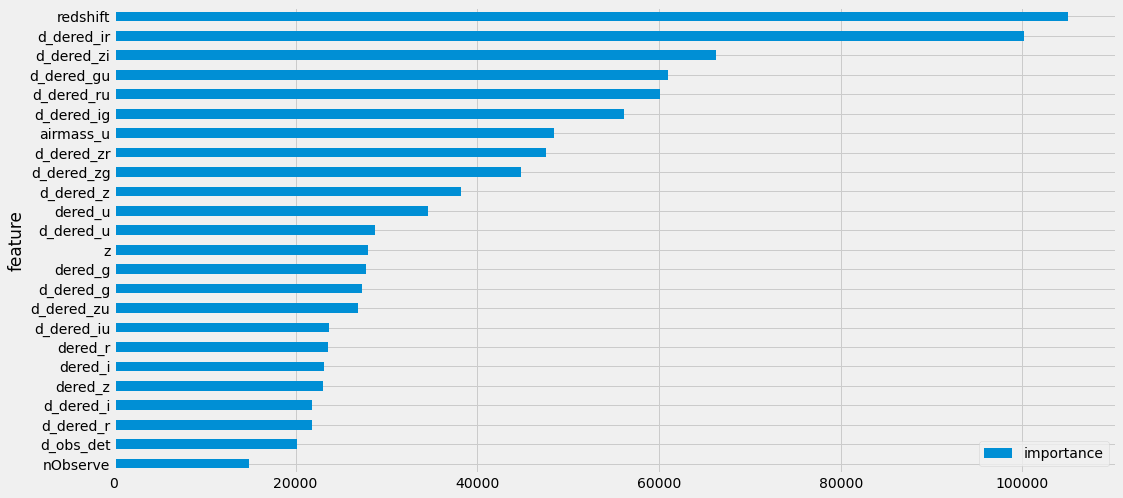

In [14]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [15]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [16]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [17]:
sub[target_col].value_counts()

2    40673
0    29978
1     9349
Name: class, dtype: int64

In [18]:
sub.to_csv(sub_file)